In [4]:
import sys
import os
import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import mpl_toolkits.axisartist
# from mpl_toolkits.axes_grid1 import host_subplot

import scipy.interpolate
import scipy.optimize
import scipy.stats
import pandas as pd

%load_ext rpy2.ipython
# import statsmodels.formula.api as smformula
# import dateutil
# from collections import OrderedDict

In [5]:
from IPython.display import display, HTML
%matplotlib notebook
plt.style.use('seaborn-paper')

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [6]:
# constants
FN = '2017_MAT_rep{}data.xlsx'
treatments = ['Low', 'High', 'Super High']

In [7]:
def load_rep_catch_data(rep, filename_pattern):
    df = pd.read_excel(filename_pattern.format(rep))

    if rep in [1,2]:
        foo = df[['Date Collected','Treatment','Row','Trap #','Pink','Blue','Yellow','Arc Yellow']].copy(deep=True)
        foo = foo[pd.notnull(foo['Date Collected'])]
        foo.loc[:,['Pink','Blue','Yellow','Arc Yellow']] = foo.loc[:,['Pink','Blue','Yellow','Arc Yellow']].fillna(value=0)
        foo['Total'] = foo.loc[:,['Pink','Blue','Yellow','Arc Yellow']].sum(axis=1)
    else:
        foo = df[['Date','Treatment','Row','Trap #','# recaptured']].copy(deep=True)
        foo.rename(columns={'Date':'Date Collected', '# recaptured':'Total'}, inplace=True)
        foo = foo[pd.notnull(foo['Date Collected'])]
        foo['Total'] = foo['Total'].fillna(value=0)

    return foo

## Trap locations

In [8]:
COLSPACE = 4.5 # distance between trees along a row
ROWSPACE = 8.5 # distance between rows

FIRST_ROW_BREAK_DIST = 40 # distance between traps 4 and 5 on first row 

# Trap x positions
# even rows (starting with 0)
tx0 = (np.linspace(0, 90, 4)+15)*COLSPACE
tx0 = np.concatenate((tx0, [0*COLSPACE, 30*COLSPACE]+tx0[-1]+FIRST_ROW_BREAK_DIST*COLSPACE))
# odd rows
tx1 = (np.linspace(0, 90, 4)+30)*COLSPACE
tx1 = np.concatenate((tx1, [0*COLSPACE]+tx1[-1]+FIRST_ROW_BREAK_DIST*COLSPACE))

# nominal trap positions
tx = []
ty = []
for row in range(5,50+1, 5):
    if row%10 == 5:
        tx.extend(tx0)
        ty.extend([row*ROWSPACE]*len(tx0))
    else:
        tx.extend(tx1)
        ty.extend([row*ROWSPACE]*len(tx1))

# high block positions
hbx = []
hby = []
for row in range(5,50+1, 5):
    if row%10 == 5:
        hbx.extend(tx1)
        hby.extend([row*ROWSPACE]*len(tx1))
    else:
        hbx.extend(tx0)
        hby.extend([row*ROWSPACE]*len(tx0))

# super-high block positions
tmp = np.linspace(0, 120*COLSPACE, 17)
#tmp = tmp*COLSPACE
shbx0 = np.concatenate((tmp, np.linspace(0,30*COLSPACE,5)+(105*COLSPACE+FIRST_ROW_BREAK_DIST*COLSPACE)))
shbx0 = shbx0[np.in1d(shbx0, tx0, invert=True)]
shbx1 = np.concatenate((tmp+7.5*COLSPACE, np.linspace(0,30*COLSPACE,5)+(105*COLSPACE+FIRST_ROW_BREAK_DIST*COLSPACE)))
# shbx1 = np.concatenate((tmp+7.5*COLSPACE, np.linspace(0,30,5)+(105+FIRST_ROW_BREAK_DIST)))
shbx1 = shbx1[np.in1d(shbx1, tx1, invert=True)]
shbx = []
shby = []
for row in range(5,50+1, 5):
    if row%10 == 5:
        shbx.extend(shbx0)
        shby.extend([row*ROWSPACE]*len(shbx0))
    else:
        shbx.extend(shbx1)
        shby.extend([row*ROWSPACE]*len(shbx1))


<IPython.core.display.Javascript object>


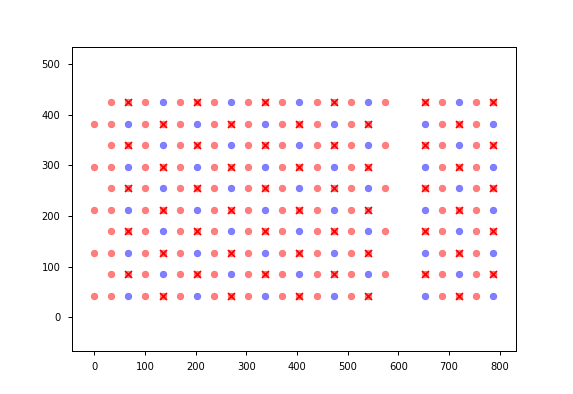

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(tx, ty, color='b', alpha=0.5)
ax.scatter(hbx, hby, marker='x', color='r')
ax.scatter(shbx, shby, color='r', alpha=0.5)
ax.set_aspect('equal','datalim')

In [10]:
df = load_rep_catch_data(1, FN)
df['x'] = df.apply(lambda r: tx0[int(r['Trap #'])-1] 
                   if int(r['Row']%10) == 5
                   else tx1[int(r['Trap #'])-1],
                   axis=1) 
df['y'] = df['Row'] * ROWSPACE
df = df[(df['Date Collected']=='2017-04-13') & (df['Treatment']=='Low')]
display(df)
df['Total'].sum()

,Date Collected,Treatment,Row,Trap #,Pink,Blue,Yellow,Arc Yellow,Total,x,y
0,2017-04-13,Low,5.0,1.0,0.0,0.0,0.0,0.0,0.0,67.5,42.5
1,2017-04-13,Low,5.0,2.0,0.0,0.0,0.0,0.0,0.0,202.5,42.5
2,2017-04-13,Low,5.0,3.0,0.0,0.0,0.0,0.0,0.0,337.5,42.5
3,2017-04-13,Low,5.0,4.0,0.0,0.0,0.0,0.0,0.0,472.5,42.5
4,2017-04-13,Low,5.0,5.0,1.0,0.0,0.0,0.0,1.0,652.5,42.5
5,2017-04-13,Low,5.0,6.0,0.0,0.0,0.0,0.0,0.0,787.5,42.5
6,2017-04-13,Low,10.0,1.0,0.0,0.0,0.0,0.0,0.0,135.0,85.0
7,2017-04-13,Low,10.0,2.0,2.0,0.0,0.0,0.0,2.0,270.0,85.0
8,2017-04-13,Low,10.0,3.0,0.0,0.0,0.0,0.0,0.0,405.0,85.0
9,2017-04-13,Low,10.0,4.0,0.0,0.0,0.0,0.0,0.0,540.0,85.0


1700.0

<IPython.core.display.Javascript object>


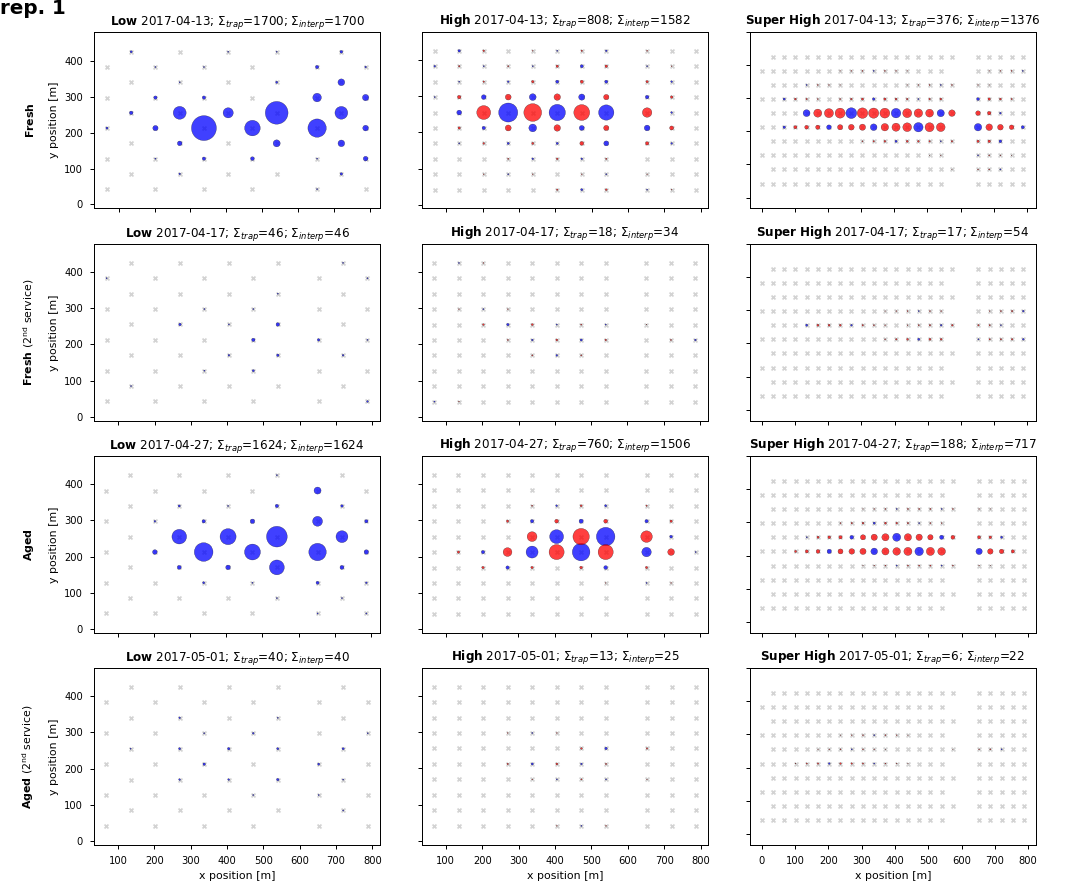

$\mathbf{Low}$ 2017-04-13; $\Sigma_{trap}$=1700; $\Sigma_{interp}$=1700
$\mathbf{Low}$ 2017-04-17; $\Sigma_{trap}$=46; $\Sigma_{interp}$=46
$\mathbf{Low}$ 2017-04-27; $\Sigma_{trap}$=1624; $\Sigma_{interp}$=1624
$\mathbf{Low}$ 2017-05-01; $\Sigma_{trap}$=40; $\Sigma_{interp}$=40
$\mathbf{High}$ 2017-04-13; $\Sigma_{trap}$=808; $\Sigma_{interp}$=1582
$\mathbf{High}$ 2017-04-17; $\Sigma_{trap}$=18; $\Sigma_{interp}$=34
$\mathbf{High}$ 2017-04-27; $\Sigma_{trap}$=760; $\Sigma_{interp}$=1506
$\mathbf{High}$ 2017-05-01; $\Sigma_{trap}$=13; $\Sigma_{interp}$=25
$\mathbf{Super\ High}$ 2017-04-13; $\Sigma_{trap}$=376; $\Sigma_{interp}$=1376
$\mathbf{Super\ High}$ 2017-04-17; $\Sigma_{trap}$=17; $\Sigma_{interp}$=54
$\mathbf{Super\ High}$ 2017-04-27; $\Sigma_{trap}$=188; $\Sigma_{interp}$=717
$\mathbf{Super\ High}$ 2017-05-01; $\Sigma_{trap}$=6; $\Sigma_{interp}$=22


<IPython.core.display.Javascript object>


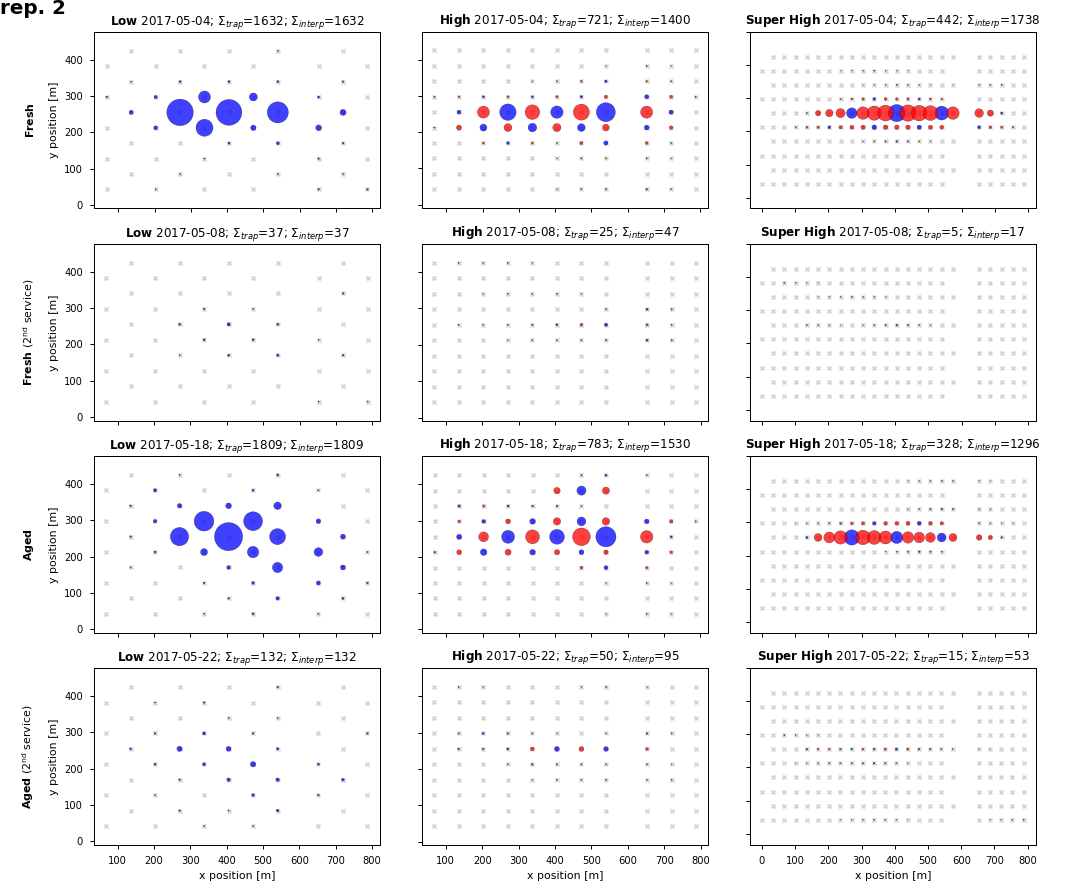

$\mathbf{Low}$ 2017-05-04; $\Sigma_{trap}$=1632; $\Sigma_{interp}$=1632
$\mathbf{Low}$ 2017-05-08; $\Sigma_{trap}$=37; $\Sigma_{interp}$=37
$\mathbf{Low}$ 2017-05-18; $\Sigma_{trap}$=1809; $\Sigma_{interp}$=1809
$\mathbf{Low}$ 2017-05-22; $\Sigma_{trap}$=132; $\Sigma_{interp}$=132
$\mathbf{High}$ 2017-05-04; $\Sigma_{trap}$=721; $\Sigma_{interp}$=1400
$\mathbf{High}$ 2017-05-08; $\Sigma_{trap}$=25; $\Sigma_{interp}$=47
$\mathbf{High}$ 2017-05-18; $\Sigma_{trap}$=783; $\Sigma_{interp}$=1530
$\mathbf{High}$ 2017-05-22; $\Sigma_{trap}$=50; $\Sigma_{interp}$=95
$\mathbf{Super\ High}$ 2017-05-04; $\Sigma_{trap}$=442; $\Sigma_{interp}$=1738
$\mathbf{Super\ High}$ 2017-05-08; $\Sigma_{trap}$=5; $\Sigma_{interp}$=17
$\mathbf{Super\ High}$ 2017-05-18; $\Sigma_{trap}$=328; $\Sigma_{interp}$=1296
$\mathbf{Super\ High}$ 2017-05-22; $\Sigma_{trap}$=15; $\Sigma_{interp}$=53


<IPython.core.display.Javascript object>


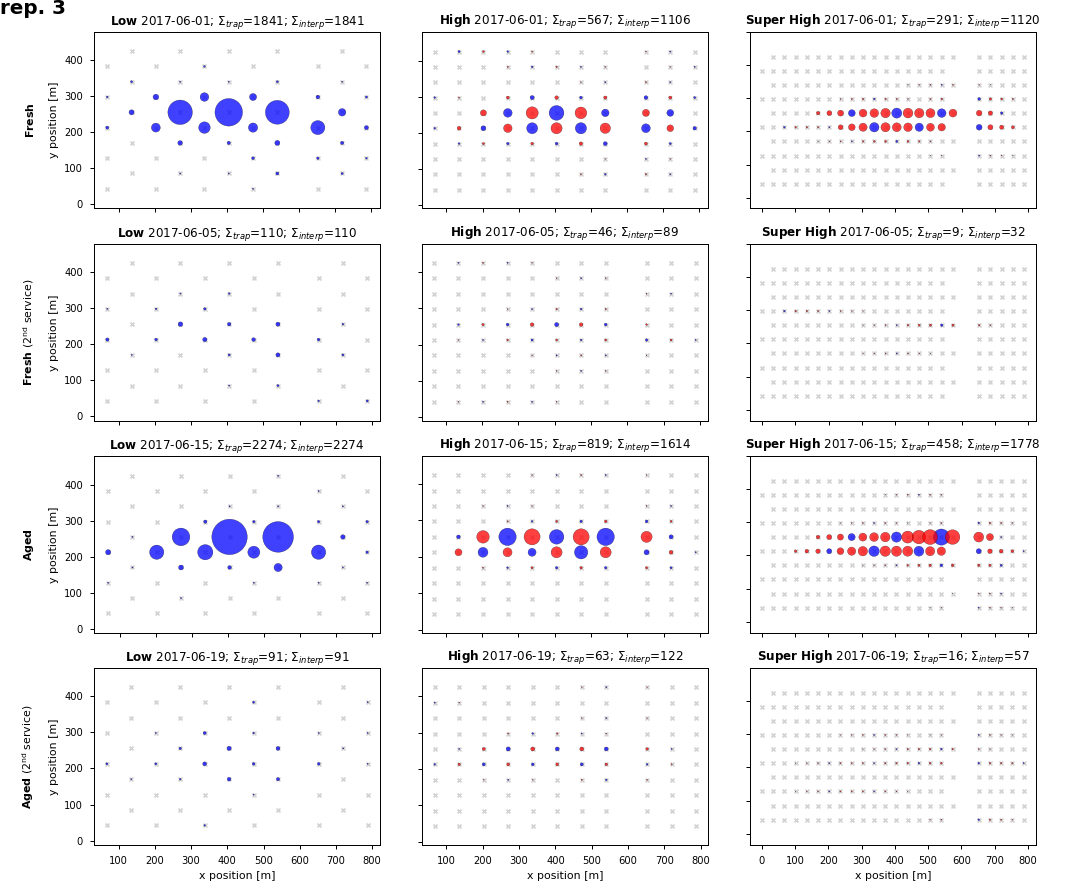

$\mathbf{Low}$ 2017-06-01; $\Sigma_{trap}$=1841; $\Sigma_{interp}$=1841
$\mathbf{Low}$ 2017-06-05; $\Sigma_{trap}$=110; $\Sigma_{interp}$=110
$\mathbf{Low}$ 2017-06-15; $\Sigma_{trap}$=2274; $\Sigma_{interp}$=2274
$\mathbf{Low}$ 2017-06-19; $\Sigma_{trap}$=91; $\Sigma_{interp}$=91
$\mathbf{High}$ 2017-06-01; $\Sigma_{trap}$=567; $\Sigma_{interp}$=1106
$\mathbf{High}$ 2017-06-05; $\Sigma_{trap}$=46; $\Sigma_{interp}$=89
$\mathbf{High}$ 2017-06-15; $\Sigma_{trap}$=819; $\Sigma_{interp}$=1614
$\mathbf{High}$ 2017-06-19; $\Sigma_{trap}$=63; $\Sigma_{interp}$=122
$\mathbf{Super\ High}$ 2017-06-01; $\Sigma_{trap}$=291; $\Sigma_{interp}$=1120
$\mathbf{Super\ High}$ 2017-06-05; $\Sigma_{trap}$=9; $\Sigma_{interp}$=32
$\mathbf{Super\ High}$ 2017-06-15; $\Sigma_{trap}$=458; $\Sigma_{interp}$=1778
$\mathbf{Super\ High}$ 2017-06-19; $\Sigma_{trap}$=16; $\Sigma_{interp}$=57


<IPython.core.display.Javascript object>


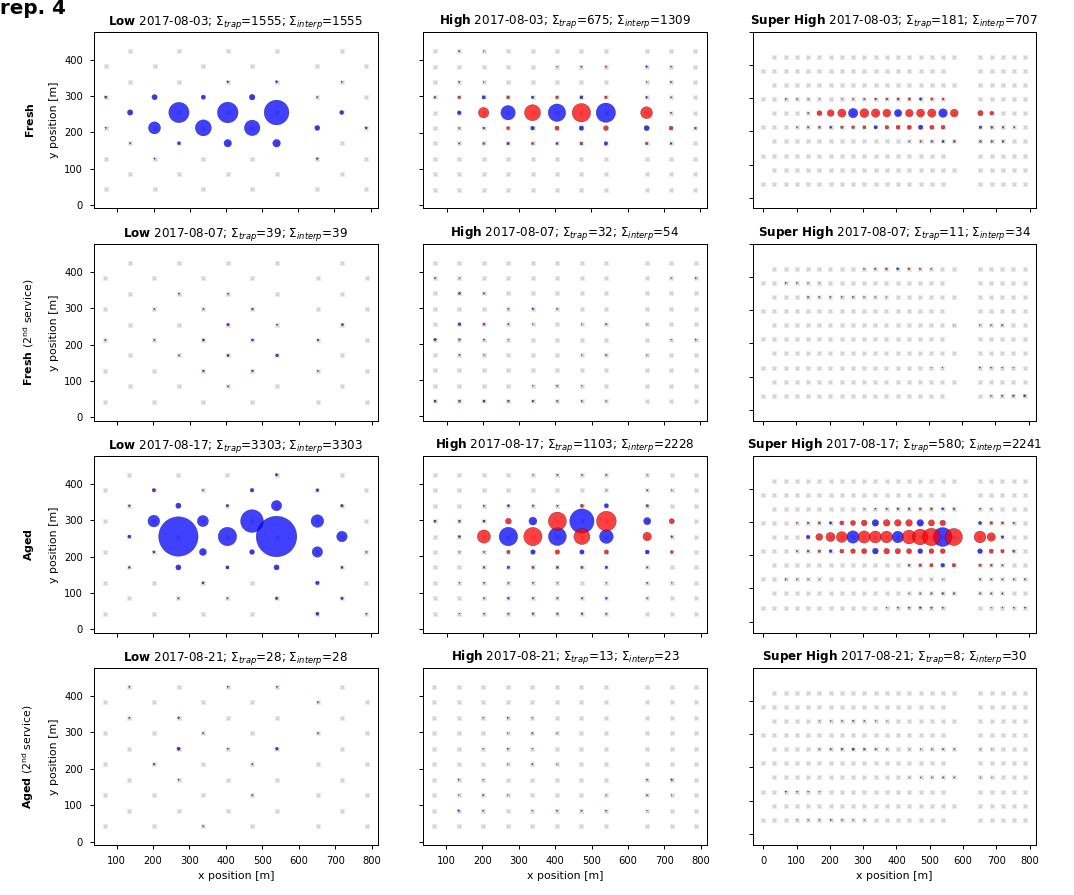

$\mathbf{Low}$ 2017-08-03; $\Sigma_{trap}$=1555; $\Sigma_{interp}$=1555
$\mathbf{Low}$ 2017-08-07; $\Sigma_{trap}$=39; $\Sigma_{interp}$=39
$\mathbf{Low}$ 2017-08-17; $\Sigma_{trap}$=3303; $\Sigma_{interp}$=3303
$\mathbf{Low}$ 2017-08-21; $\Sigma_{trap}$=28; $\Sigma_{interp}$=28
$\mathbf{High}$ 2017-08-03; $\Sigma_{trap}$=675; $\Sigma_{interp}$=1309
$\mathbf{High}$ 2017-08-07; $\Sigma_{trap}$=32; $\Sigma_{interp}$=54
$\mathbf{High}$ 2017-08-17; $\Sigma_{trap}$=1103; $\Sigma_{interp}$=2228
$\mathbf{High}$ 2017-08-21; $\Sigma_{trap}$=13; $\Sigma_{interp}$=23
$\mathbf{Super\ High}$ 2017-08-03; $\Sigma_{trap}$=181; $\Sigma_{interp}$=707
$\mathbf{Super\ High}$ 2017-08-07; $\Sigma_{trap}$=11; $\Sigma_{interp}$=34
$\mathbf{Super\ High}$ 2017-08-17; $\Sigma_{trap}$=580; $\Sigma_{interp}$=2241
$\mathbf{Super\ High}$ 2017-08-21; $\Sigma_{trap}$=8; $\Sigma_{interp}$=30


<IPython.core.display.Javascript object>


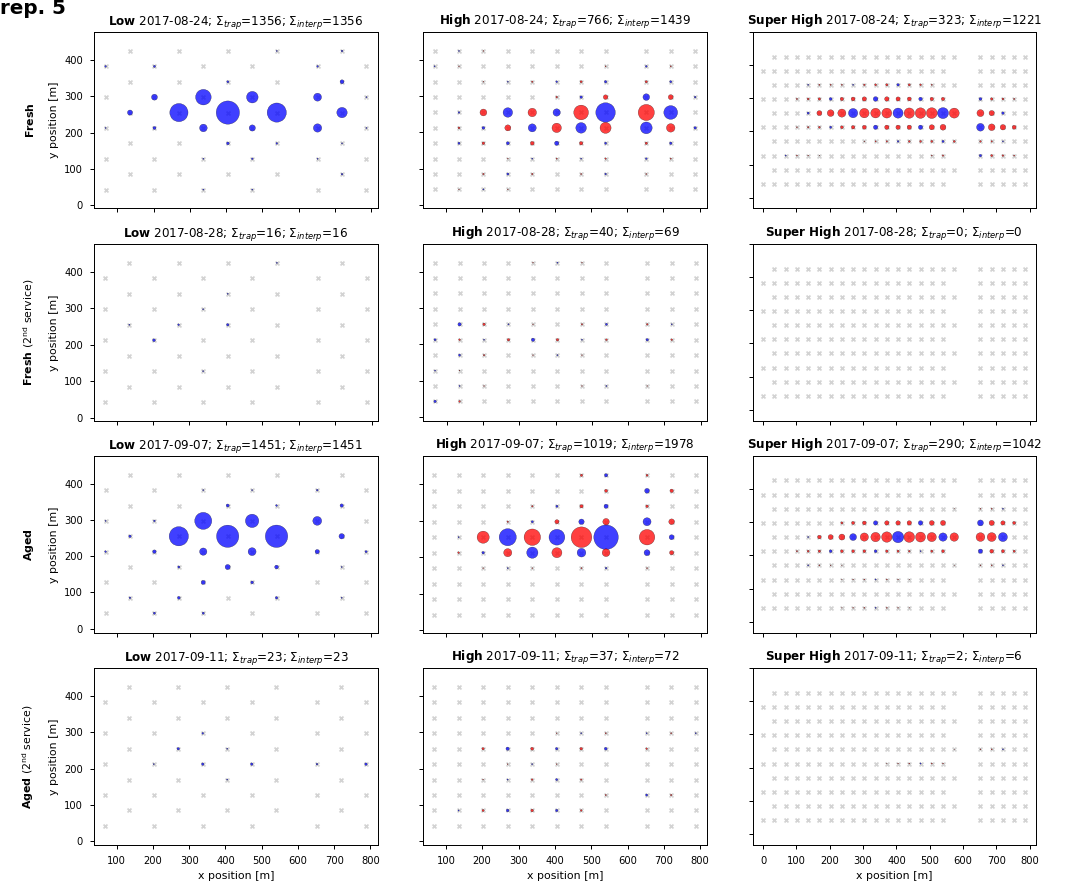

$\mathbf{Low}$ 2017-08-24; $\Sigma_{trap}$=1356; $\Sigma_{interp}$=1356
$\mathbf{Low}$ 2017-08-28; $\Sigma_{trap}$=16; $\Sigma_{interp}$=16
$\mathbf{Low}$ 2017-09-07; $\Sigma_{trap}$=1451; $\Sigma_{interp}$=1451
$\mathbf{Low}$ 2017-09-11; $\Sigma_{trap}$=23; $\Sigma_{interp}$=23
$\mathbf{High}$ 2017-08-24; $\Sigma_{trap}$=766; $\Sigma_{interp}$=1439
$\mathbf{High}$ 2017-08-28; $\Sigma_{trap}$=40; $\Sigma_{interp}$=69
$\mathbf{High}$ 2017-09-07; $\Sigma_{trap}$=1019; $\Sigma_{interp}$=1978
$\mathbf{High}$ 2017-09-11; $\Sigma_{trap}$=37; $\Sigma_{interp}$=72
$\mathbf{Super\ High}$ 2017-08-24; $\Sigma_{trap}$=323; $\Sigma_{interp}$=1221
$\mathbf{Super\ High}$ 2017-08-28; $\Sigma_{trap}$=0; $\Sigma_{interp}$=0
$\mathbf{Super\ High}$ 2017-09-07; $\Sigma_{trap}$=290; $\Sigma_{interp}$=1042
$\mathbf{Super\ High}$ 2017-09-11; $\Sigma_{trap}$=2; $\Sigma_{interp}$=6


<IPython.core.display.Javascript object>


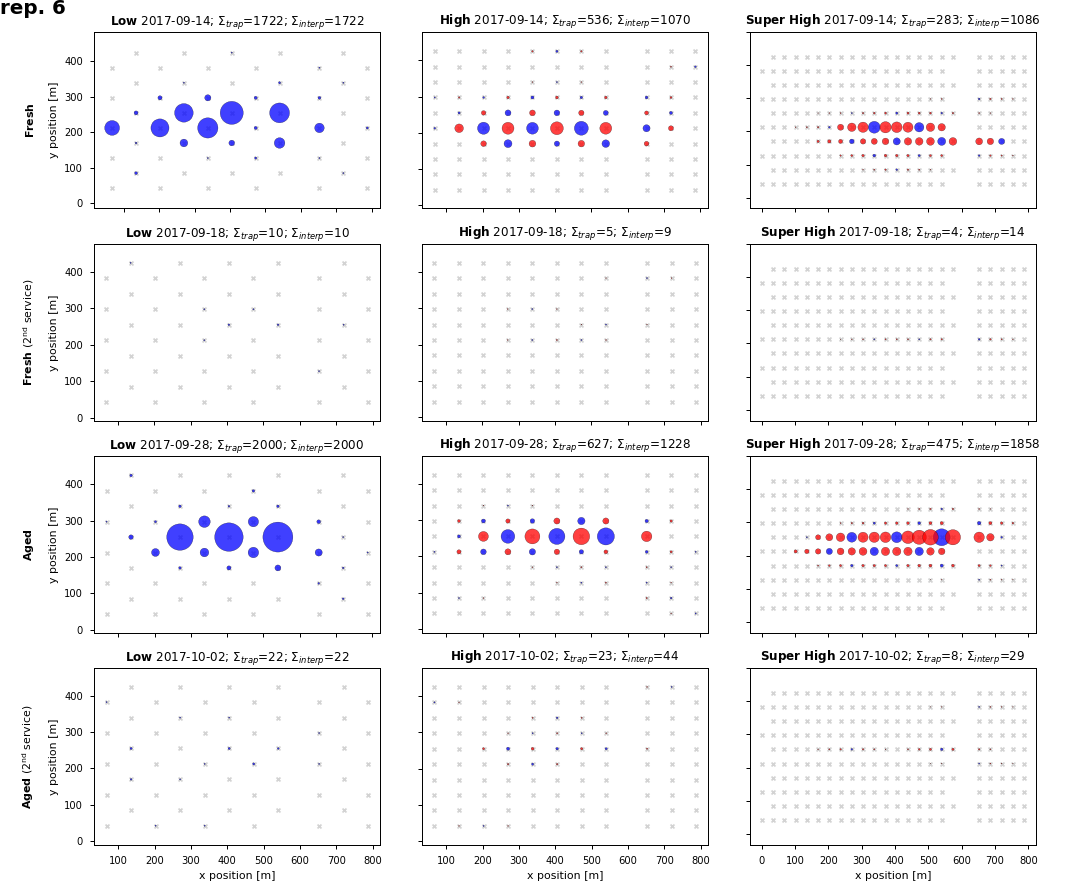

$\mathbf{Low}$ 2017-09-14; $\Sigma_{trap}$=1722; $\Sigma_{interp}$=1722
$\mathbf{Low}$ 2017-09-18; $\Sigma_{trap}$=10; $\Sigma_{interp}$=10
$\mathbf{Low}$ 2017-09-28; $\Sigma_{trap}$=2000; $\Sigma_{interp}$=2000
$\mathbf{Low}$ 2017-10-02; $\Sigma_{trap}$=22; $\Sigma_{interp}$=22
$\mathbf{High}$ 2017-09-14; $\Sigma_{trap}$=536; $\Sigma_{interp}$=1070
$\mathbf{High}$ 2017-09-18; $\Sigma_{trap}$=5; $\Sigma_{interp}$=9
$\mathbf{High}$ 2017-09-28; $\Sigma_{trap}$=627; $\Sigma_{interp}$=1228
$\mathbf{High}$ 2017-10-02; $\Sigma_{trap}$=23; $\Sigma_{interp}$=44
$\mathbf{Super\ High}$ 2017-09-14; $\Sigma_{trap}$=283; $\Sigma_{interp}$=1086
$\mathbf{Super\ High}$ 2017-09-18; $\Sigma_{trap}$=4; $\Sigma_{interp}$=14
$\mathbf{Super\ High}$ 2017-09-28; $\Sigma_{trap}$=475; $\Sigma_{interp}$=1858
$\mathbf{Super\ High}$ 2017-10-02; $\Sigma_{trap}$=8; $\Sigma_{interp}$=29


In [11]:
innerx0 = 200 #tx0[2] # incluse
innerx1 = 600 #tx0[4] # not inclusive

treatments = ['Low', 'High', 'Super High']
plot_flag = True

summary = []

for rep in np.arange(1,7):
    df = load_rep_catch_data(rep, FN)
    # and x,y cols for positions
    df['x'] = df.apply(lambda r: tx0[int(r['Trap #'])-1] 
                       if int(r['Row']%10) == 5
                       else tx1[int(r['Trap #'])-1],
                       axis=1) 
    df['y'] = df['Row'] * ROWSPACE
    
    if plot_flag:
        fig, axs = plt.subplots(4, len(treatments), figsize=(12,10))

    for ti, treatment in enumerate(treatments):
        tmp = df[df['Treatment'] == treatment]
        service_dates = pd.to_datetime(tmp['Date Collected'].unique())
        assert len(service_dates) == 4

        if treatment == 'High':
            est_kill_mul = 2
            bx = hbx
            by = hby
        elif treatment == 'Super High':
            est_kill_mul = 4
            bx = shbx
            by = shby
        else:
            assert treatment == 'Low'
            est_kill_mul = 1
            bx = []
            by = []
            
        for di, service_date in enumerate(service_dates):
            foo = df[df['Treatment'] == treatment].copy(deep=True)
            foo = foo[foo['Date Collected'] == service_date]

            foo['isTrap'] = True
            foo['iT'] = foo['Total']
            foo_traps = foo.copy(deep=True) # keep a copy of just the traps
            
            # Add in the blocks
            foo = foo.append(pd.DataFrame({'x':bx, 'y':by}),
                       ignore_index=True)
            foo.sort_values(['y','x'], inplace=True)
            foo.reset_index(inplace=True, drop=True)

            # interpolate
            out = foo.copy(deep=True)
            ## 1D (row wise) interpolation
            for row in sorted(foo['y'].unique()):
                tmp = foo[foo['y']==row].sort_values('x')
                tmp2 = tmp.dropna(subset=['Total'])
                iT = scipy.interpolate.interp1d(tmp2['x'], tmp2['Total'], 
                                                kind='linear', copy=True, bounds_error=False, 
                                                fill_value=np.nan, assume_sorted=False)(tmp['x'])
                out.loc[tmp.index,'iT'] = iT
#             ## just using row mean value
#             row_mean_catch = out.loc[out['isTrap'] == True].groupby('y')['Total'].mean()
#             for y in row_mean_catch.index:
#                 out.loc[(out['y']==y)&(out['isTrap']!=True), 'iT'] = row_mean_catch.loc[y]

#             print(
#                 out.loc[out['isTrap'] == True].groupby('y')['Total'].count(),
#                 out.loc[out['isTrap'] == True].groupby('y')['Total'].sum(),
#                 out.loc[out['isTrap'] == True].groupby('y')['Total'].mean(),
#             )
                
            # sums
            tmp = out#.copy(deep=True)
            sum_all = tmp['iT'].sum()
            tmp = tmp[(tmp['x']>=innerx0) & (tmp['x']<innerx1)] # restrict to inner columns
            sum_inner_cols = tmp['iT'].sum()
            
            summary.append({'rep':rep,
                            'treatment':treatment,
                            'service #':di,
                            'service date':service_date,
                            'aged':di>1,
                            'trap kill':int(out.loc[out['isTrap']==True, 'Total'].sum()),
                            'est. kill':int(out.loc[out['isTrap']==True, 'Total'].sum())*est_kill_mul,
                            'interp. kill':int(out['iT'].sum()),
                           })

            if plot_flag:
                # Plot
                ax = axs[di,ti]
                # all traps+hats (markers)
                ax.scatter(x=out['x'], y=out['y'], s=10, marker='x', color='lightgray')
                # All
                tmp1 = out
                tmp = out[tmp1['isTrap']==True]
                ax.scatter(tmp['x'], tmp['y'], tmp['iT'], color='b', edgecolor='k', alpha=0.75)
                tmp = tmp1[tmp1['isTrap']!=True]
                ax.scatter(tmp['x'], tmp['y'], tmp['iT'], color='r', edgecolor='k', alpha=0.75)
                # labels
                ax.set_aspect('equal','datalim')
                t = r"$\mathbf{"+treatment.replace(' ','\ ')+r"}$"
                t += " {}".format(pd.to_datetime(service_date).strftime('%Y-%m-%d'))
                t += r"; $\Sigma_{trap}$="+str(int(out.loc[out['isTrap']==True, 'Total'].sum()))
                t += r"; $\Sigma_{interp}$="+str(int(out['iT'].sum()))
                ax.set_title(t)
                print(t)
                if ti>0:
                    ax.set_yticklabels([])
                if di<len(service_dates)-1:
                    ax.set_xticklabels([])
                if ti == 0:
                    if di == 0:
                        t = r"$\mathrm{\mathbf{Fresh}}$"
                    elif di == 1:
                        t = r"$\mathrm{\mathbf{Fresh}\ (2^{nd}\ service)}$"
                    elif di == 2:
                        t = r"$\mathrm{\mathbf{Aged}}$"
                    elif di == 3:
                        t = r"$\mathrm{\mathbf{Aged}\ (2^{nd}\ service)}$"
                    else:
                        raise RuntimeError("Shouldn't get here")
                    ax.set_ylabel(t+"\n\ny position [m]")
                if di == len(service_dates)-1:
                    ax.set_xlabel("x position [m]")

    if plot_flag:
        ax.text(0,1, 'rep. {}'.format(rep), transform=fig.transFigure, fontsize=16, fontweight='bold', va='top', ha='left')
        fig.tight_layout()
        fig.savefig('rep{}_inferred.png'.format(rep))

sdf = pd.DataFrame(summary)

In [12]:
# sdf = pd.DataFrame(summary)
sdf

,aged,est. kill,interp. kill,rep,service #,service date,trap kill,treatment
0,False,1700,1700,1,0,2017-04-13,1700,Low
1,False,46,46,1,1,2017-04-17,46,Low
2,True,1624,1624,1,2,2017-04-27,1624,Low
3,True,40,40,1,3,2017-05-01,40,Low
4,False,1616,1582,1,0,2017-04-13,808,High
5,False,36,34,1,1,2017-04-17,18,High
6,True,1520,1506,1,2,2017-04-27,760,High
7,True,26,25,1,3,2017-05-01,13,High
8,False,1504,1376,1,0,2017-04-13,376,Super High
9,False,68,54,1,1,2017-04-17,17,Super High


In [38]:
# t = sdf.copy(deep=True)
# t['treatment'] = t['treatment'].replace({'Low':'110', 'High':'220', 'Super High':'440'})
# # t['treatment'] = pd.Categorical(t['treatment'], categories=['110', '220', '440'], ordered=True)
# t = t.groupby(['aged','rep','treatment']).sum().drop(['service #'], axis=1)
# t

TOTAL_NUM_FLIES = 12600
fn = '2018-05_data.csv'
d = pd.read_csv(fn)
fraction_male = 0.5
d['catchable'] = TOTAL_NUM_FLIES*fraction_male*d['Emergence']*d['Flight']*d['Me-response']
d.loc[d['treatment']=='110skm', 'treatment'] = "110"
d.loc[d['treatment']=='220skm', 'treatment'] = "220"
d.loc[d['treatment']=='440skm', 'treatment'] = "440"

# harmonize and merge with our catch data
t = sdf.copy(deep=True)
t['treatment'] = t['treatment'].replace({'Low':'110', 'High':'220', 'Super High':'440'})
# sum all the trap services (first and second in this case)
t = t.groupby(['aged','rep','treatment']).sum().drop(columns=['service #'])
t.reset_index(inplace=True)
# recode a bit to make it look like Nick's tables
t['age'] = '01d'
t.loc[t['aged'], 'age'] = '14d'

t = t.merge(d, how='outer', on=['rep','age','treatment'])
t['interp. kill %'] = t['interp. kill']/t['catchable']
t['est. kill %'] = t['est. kill']/t['catchable']
t


FileNotFoundError: File b'2018-05_data.csv' does not exist

In [24]:
t = sdf.copy(deep=True)
t['treatment'] = pd.Categorical(t['treatment'], categories=['Low', 'High', 'Super High'], ordered=True)
t['treatment'] = t['treatment'].cat.rename_categories({'Low':'110', 'High':'220', 'Super High':'440'})
t = t.groupby(['aged','rep','treatment']).sum().drop(['service #'], axis=1)
t

est. kill  interp. kill  trap kill
aged  rep treatment                                     
False 1   Low              1746          1746       1746
          High             1652          1616        826
          Super High       1572          1430        393
      2   Low              1669          1669       1669
          High             1492          1447        746
          Super High       1788          1755        447
      3   Low              1951          1951       1951
          High             1226          1195        613
          Super High       1200          1152        300
      4   Low              1594          1594       1594
          High             1414          1363        707
          Super High        768           741        192
      5   Low              1372          1372       1372
          High             1612          1508        806
          Super High       1292          1221        323
      6   Low              1732          1732       1732
          High             1082          1079        541
          Super High       1148          1100        287
True  1   Low              1664          1664       1664
          High             1546          1531        773
          Super High        776           739        194
      2   Low              1941          1941       1941
          High             1666          1625        833
          Super High       1372          1349        343
      3   Low              2365          2365       2365
          High             1764          1736        882
          Super High       1896          1835        474
      4   Low              3331          3331       3331
          High             2232          2251       1116
          Super High       2352          2271        588
      5   Low              1474          1474       1474
          High             2112          2050       1056
          Super High       1168          1048        292
      6   Low              2022          2022       2022
          High             1300          1272        650
          Super High       1932          1887        483

In [16]:
t = sdf.copy(deep=True)
t['treatment'] = pd.Categorical(t['treatment'], categories=['Low', 'High', 'Super High'], ordered=True)
t = t.groupby(['aged','rep','treatment']).sum().drop(['service #'], axis=1)
t

est. kill  interp. kill  trap kill
aged  rep treatment                                     
False 1   Low              1746          1746       1746
          High             1652          1616        826
          Super High       1572          1430        393
      2   Low              1669          1669       1669
          High             1492          1447        746
          Super High       1788          1755        447
      3   Low              1951          1951       1951
          High             1226          1195        613
          Super High       1200          1152        300
      4   Low              1594          1594       1594
          High             1414          1363        707
          Super High        768           741        192
      5   Low              1372          1372       1372
          High             1612          1508        806
          Super High       1292          1221        323
      6   Low              1732          1732       1732
          High             1082          1079        541
          Super High       1148          1100        287
True  1   Low              1664          1664       1664
          High             1546          1531        773
          Super High        776           739        194
      2   Low              1941          1941       1941
          High             1666          1625        833
          Super High       1372          1349        343
      3   Low              2365          2365       2365
          High             1764          1736        882
          Super High       1896          1835        474
      4   Low              3331          3331       3331
          High             2232          2251       1116
          Super High       2352          2271        588
      5   Low              1474          1474       1474
          High             2112          2050       1056
          Super High       1168          1048        292
      6   Low              2022          2022       2022
          High             1300          1272        650
          Super High       1932          1887        483

In [483]:
t.loc[(False,slice(None),'High')]

est. kill  interp. kill  trap kill
aged  rep treatment                                    
False 1   High            1652          1616        826
      2   High            1492          1447        746
      3   High            1226          1195        613
      4   High            1414          1363        707
      5   High            1612          1508        806
      6   High            1082          1079        541

## replicating Nick's R analysis

In [509]:
# Get the estimated number of potential responders released (number catchable) and merge with catch data
TOTAL_NUM_FLIES = 12600
fn = '2018-05_data.csv'
d = pd.read_csv(fn)
fraction_male = 0.5
d['catchable'] = TOTAL_NUM_FLIES*fraction_male*d['Emergence']*d['Flight']*d['Me-response']
d.loc[d['treatment']=='110skm', 'treatment'] = "Low"
d.loc[d['treatment']=='220skm', 'treatment'] = "High"
d.loc[d['treatment']=='440skm', 'treatment'] = "Super High"

# harmonize and merge with our catch data
t = sdf.copy(deep=True)
t['treatment'] = pd.Categorical(t['treatment'], categories=['Low', 'High', 'Super High'], ordered=True)
# sum all the trap services (first and second in this case)
t = t.groupby(['aged','rep','treatment']).sum().drop(columns=['service #'])
t.reset_index(inplace=True)
# recode a bit to make it look like Nick's tables
t['age'] = '01d'
t.loc[t['aged'], 'age'] = '14d'

t = t.merge(d, how='outer', on=['rep','age','treatment'])
t['interp. kill %'] = t['interp. kill']/t['catchable']
t['est. kill %'] = t['est. kill']/t['catchable']
t

,aged,rep,treatment,est. kill,interp. kill,trap kill,age,date,plot,no. recap,...,Emergence,Flight,Me-response,pctkill,protein-F,protein-M,treatage,catchable,interp. kill %,est. kill %
0,False,1,Low,1746,1746,1746,01d,4/12/2017,A,1746,...,0.895,0.855,0.850,0.426084,2,0,01d110,4097.779875,0.426084,0.426084
1,False,1,High,1652,1616,826,01d,4/12/2017,B,826,...,0.895,0.855,0.850,0.403145,0,0,01d220,4097.779875,0.394360,0.403145
2,False,1,Super High,1572,1430,393,01d,4/12/2017,C,393,...,0.895,0.855,0.850,0.383622,1,0,01d440,4097.779875,0.348969,0.383622
3,False,2,Low,1669,1669,1669,01d,5/3/2017,C,1669,...,0.900,0.880,0.733,0.456338,4,0,01d110,3657.376800,0.456338,0.456338
4,False,2,High,1492,1447,746,01d,5/3/2017,A,746,...,0.900,0.880,0.733,0.407943,3,0,01d220,3657.376800,0.395639,0.407943
5,False,2,Super High,1788,1755,447,01d,5/3/2017,B,447,...,0.900,0.880,0.733,0.488875,3,0,01d440,3657.376800,0.479852,0.488875
6,False,3,Low,1951,1951,1951,01d,5/31/2017,B,1951,...,0.905,0.820,0.733,0.569312,6,0,01d110,3426.943590,0.569312,0.569312
7,False,3,High,1226,1195,613,01d,5/31/2017,C,613,...,0.905,0.820,0.733,0.357753,6,0,01d220,3426.943590,0.348707,0.357753
8,False,3,Super High,1200,1152,300,01d,5/31/2017,A,300,...,0.905,0.820,0.733,0.350166,7,1,01d440,3426.943590,0.336160,0.350166
9,False,4,Low,1594,1594,1594,01d,8/1/2017,A,1594,...,0.980,0.860,0.933,0.321767,9,0,01d110,4953.894120,0.321767,0.321767


In [530]:
dat = t.copy(deep=True)
dat['pctkill'] = dat['est. kill %']
dat['interpkill'] = dat['interp. kill']


In [528]:
%%R -i dat
attach(dat)
pdf(file='interpkill_barplot.pdf')

error.bar <- function(x, y, upper, lower=upper, length=0.1,...){
    if(length(x) != length(y) | length(y) !=length(lower) | length(lower) != length(upper))
    stop("vectors must be same length")
    arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)}
ste <- function(x) sd(x)/sqrt(length(x))
pctmeans<-aggregate(pctkill,by=list(treatment,age),mean)
pcterr<-aggregate(pctkill,by=list(treatment,age),ste)
col3<-c("white","gray50","gray88")
col6<-c(col3,col3)
bplot<-barplot(pctmeans$x,col=col6,xlab="Density, Age [spots/km2, d]",ylab="Estimated kill [%]", ylim=c(0,.6))
error.bar(bplot,pctmeans$x,pcterr$x)
legend("topright",c("110","220","440"),fill=col3)
dev.off()

/home/travc/miniconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following objects are masked from dat (pos = 3):

    age, aged, catchable, date, Emergence, est..kill, est..kill..,
    estkill, Flight, interp..kill, interp..kill.., Me.response,
    no..recap, pctkill, plot, protein.F, protein.M, rep, trap.kill,
    treatage, treatment


  warnings.warn(x, RRuntimeWarning)
/home/travc/miniconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following objects are masked from dat (pos = 4):

    age, aged, catchable, date, Emergence, est..kill, est..kill..,
    estkill, Flight, interp..kill, interp..kill.., Me.response,
    no..recap, pctkill, plot, protein.F, protein.M, rep, trap.kill,
    treatage, treatment


  warnings.warn(x, RRuntimeWarning)
/home/travc/miniconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following objects are masked from dat (pos = 5):

    age, aged

png 
  2 


#### homogeneity tests

In [537]:
%%R
bartlett.test(interpkill~treatment, data=dat)


	Bartlett test of homogeneity of variances

data:  interpkill by treatment
Bartlett's K-squared = 2.0191, df = 2, p-value = 0.3644



In [546]:
%%R
bartlett.test(interpkill~age, data=dat)


	Bartlett test of homogeneity of variances

data:  interpkill by age
Bartlett's K-squared = 6.2458, df = 1, p-value = 0.01245



not good, try log transform (just like Nick did)

In [548]:
%%R
bartlett.test(log(interpkill)~treatment,data=dat)


	Bartlett test of homogeneity of variances

data:  log(interpkill) by treatment
Bartlett's K-squared = 3.3972, df = 2, p-value = 0.1829



In [549]:
%%R
bartlett.test(log(interpkill)~age,data=dat)


	Bartlett test of homogeneity of variances

data:  log(interpkill) by age
Bartlett's K-squared = 2.0483, df = 1, p-value = 0.1524



Both look decent enough to use

In [550]:
%%R
fit<-lm(log(interpkill)~treatment*age, data=dat)
anova(fit)

Analysis of Variance Table

Response: log(interpkill)
              Df  Sum Sq Mean Sq F value  Pr(>F)  
treatment      2 0.75019 0.37510  5.3311 0.01045 *
age            1 0.38373 0.38373  5.4538 0.02640 *
treatment:age  2 0.00544 0.00272  0.0386 0.96215  
Residuals     30 2.11081 0.07036                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [551]:
%%R
TukeyHSD(aov(fit),'treatment',conf.level=0.95)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = fit)

$treatment
                      diff         lwr         upr     p adj
Low-High         0.1951096 -0.07185475  0.46207394 0.1862362
Super High-High -0.1578338 -0.42479815  0.10913054 0.3252897
Super High-Low  -0.3529434 -0.61990775 -0.08597906 0.0076020



## Text for supplemental

The simple method of estimating the number of flies killed by unmonitored hats presented in the paper assumes the probability a fly will find and be killed by a hat is the same as the probability for a LDT.  Those probabilities are functions of distance, so the assumption is that there is no difference in relative distance of hats and LDTs from the release point of each fly.  The trapping grid was laid out as uniformly as possible and flies released along a transect to make this a reasonable assumption in the aggregate, but vagaries of release and field conditions means it isn't perfect.
We conducted an alternative analysis estimating hat kills by linear interpolation of the LDT catches along each row (parallel with the release transect).  We believe the results of this approach are more accurate than the simple method presented in the main paper, but since the interpolation approach produces lower kill estimates, the simple approach is a more conservative test of our main results.



In [292]:
tmp = np.array(ty)
display(np.where((tmp>350)&(tmp<400)))
tmp = np.array(tx)
display(np.where((tmp>450)&(tmp<500)))

(array([44, 45, 46, 47, 48, 49]),)

(array([ 3, 14, 25, 36, 47]),)

In [295]:
df[(df['Treatment']=='High')&(df['Date Collected']=='2017-05-18')
  ]

,Date Collected,Treatment,Row,Trap #,Pink,Blue,Yellow,Arc Yellow,Total,x,y
392,2017-05-18,High,5.0,1.0,0.0,0.0,0.0,0.0,0.0,67.5,42.5
393,2017-05-18,High,5.0,2.0,0.0,0.0,0.0,0.0,0.0,202.5,42.5
394,2017-05-18,High,5.0,3.0,0.0,0.0,0.0,0.0,0.0,337.5,42.5
395,2017-05-18,High,5.0,4.0,0.0,0.0,0.0,0.0,0.0,472.5,42.5
396,2017-05-18,High,5.0,5.0,0.0,0.0,1.0,0.0,1.0,652.5,42.5
397,2017-05-18,High,5.0,6.0,0.0,0.0,0.0,0.0,0.0,787.5,42.5
398,2017-05-18,High,10.0,1.0,0.0,0.0,0.0,0.0,0.0,135.0,85.0
399,2017-05-18,High,10.0,2.0,0.0,0.0,0.0,0.0,0.0,270.0,85.0
400,2017-05-18,High,10.0,3.0,0.0,0.0,0.0,0.0,0.0,405.0,85.0
401,2017-05-18,High,10.0,4.0,0.0,0.0,0.0,0.0,0.0,540.0,85.0


DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)

<IPython.core.display.Javascript object>


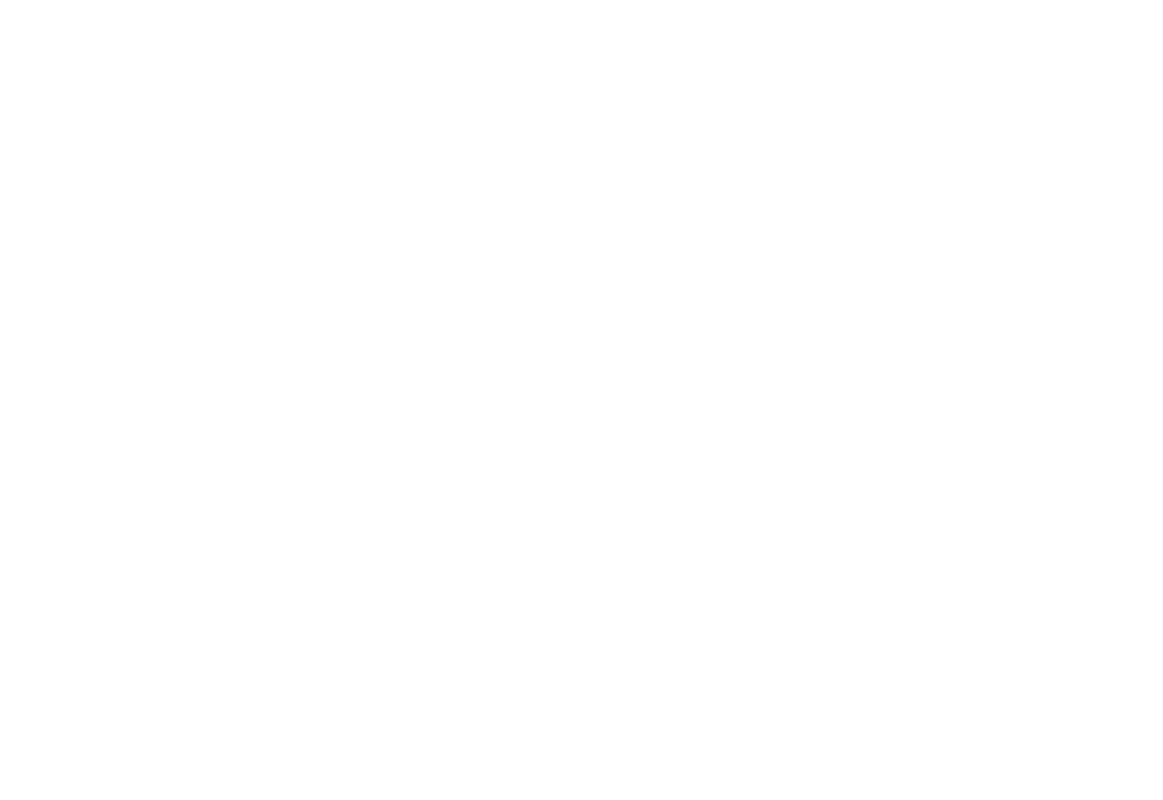

In [8]:
# Interploation... 1D vs 2D
# 2D doesn't make sense here, but is interesting comparison and useful for future point release work
rep = 1
treatment = 'Super High'
service_number = 0

df = load_rep_catch_data(rep, FN)
df['x'] = df.apply(lambda r: tx0[int(r['Trap #'])-1] 
                   if int(r['Row']%10) == 5
                   else tx1[int(r['Trap #'])-1],
                   axis=1) 
df['y'] = df['Row'] * ROWSPACE

tmp = df[df['Treatment'] == treatment]
service_dates = pd.to_datetime(tmp['Date Collected'].unique())
display(service_dates)
service_date = service_dates[service_number]
tmp = tmp[tmp['Date Collected'] == service_date]

# plot traps
fig = plt.figure()
ax = fig.add_subplot(1,1,1)    
x = tmp['x']
y = tmp['y']
z = tmp['Total']
ax.scatter(x, y, z, color='b', label='Traps')


### Blocks
if treatment.lower() == 'low':
    bx = []
    by = []
elif treatment.lower() == 'high':
    bx = hbx
    by = hby
elif treatment.lower() == 'super high':
    bx = shbx
    by = shby
else:
    raise RuntimeError("don't understand treatment='{}'".format(treatment))
foo = tmp.copy(deep=True)
foo['isTrap'] = True
foo = foo.append(pd.DataFrame({'x':bx, 'y':by}),
           ignore_index=True)
foo.sort_values(['y','x'], inplace=True)
foo.reset_index(inplace=True, drop=True)

# interpolate
## 1D (row wise) interpolation
out = foo.copy(deep=True)
foo['iT'] = np.nan
for row in sorted(foo['y'].unique()):
    tmp = foo[foo['y']==row].sort_values('x')
    tmp2 = tmp.dropna(subset=['Total'])
    iT = scipy.interpolate.interp1d(tmp2['x'], tmp2['Total'], 
                                    kind='linear', copy=True, bounds_error=False, 
                                    fill_value=np.nan, assume_sorted=False)(tmp['x'])
    foo.loc[tmp.index,'implied catch 1D'] = iT

# 2D interploation... Doesn't seem to make sense for transect release
# @TCC Doesn't seem to work for the cross-transect nature of the data (y and x distances aren't equivalent)
# uses x,y,z for traps only computed above
foo['implied catch 2D'] = scipy.interpolate.griddata(list(zip(x,y)),z, 
                                list(zip(foo['x'],foo['y'])),
                                method='linear', fill_value=np.nan, rescale=False)

# plot just the blocks
t2 = foo[foo['isTrap']!=True]
ax.scatter(t2['x'], t2['y'], t2['implied catch 1D'], color='r', alpha=0.5, edgecolor='none', linewidths=1, label='implied 1D')
ax.scatter(t2['x'], t2['y'], t2['implied catch 2D'], color='none', alpha=0.5, edgecolor='k', linewidths=1, label='implied 2D')
ax.set_aspect('equal','datalim')
ax.legend()

## Distribution of catch vs distance from transect

In [25]:
# Load data and filter down to single service (collection date)
rep = 1
treatment = 'Low'
service_number = 0

df = load_rep_catch_data(rep, FN)
df['x'] = df.apply(lambda r: tx0[int(r['Trap #'])-1] 
                   if int(r['Row']%10) == 5
                   else tx1[int(r['Trap #'])-1],
                   axis=1) 
df['y'] = df['Row'] * ROWSPACE

df = df[df['Treatment'] == treatment]
service_dates = pd.to_datetime(df['Date Collected'].unique())
print("Service Dates:", service_dates) # just informative output
service_date = service_dates[service_number]
df = df[df['Date Collected'] == service_date]

df['rel catch'] = df['Total']/df['Total'].sum()

Service Dates: DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)


<IPython.core.display.Javascript object>


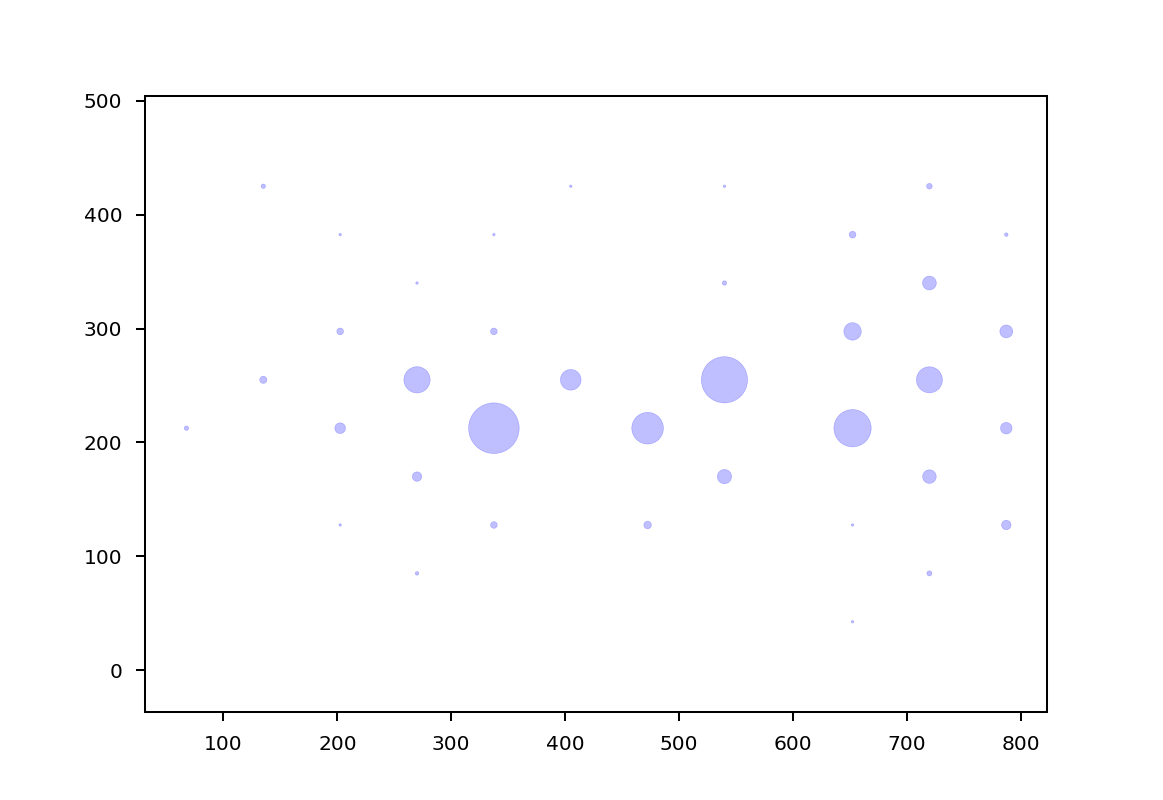

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)    
x = df['x']
y = df['y']
z = df['Total']
ax.scatter(x, y, z, color='b', alpha=0.25, label='Traps')
ax.set_aspect('equal','datalim')

<IPython.core.display.Javascript object>


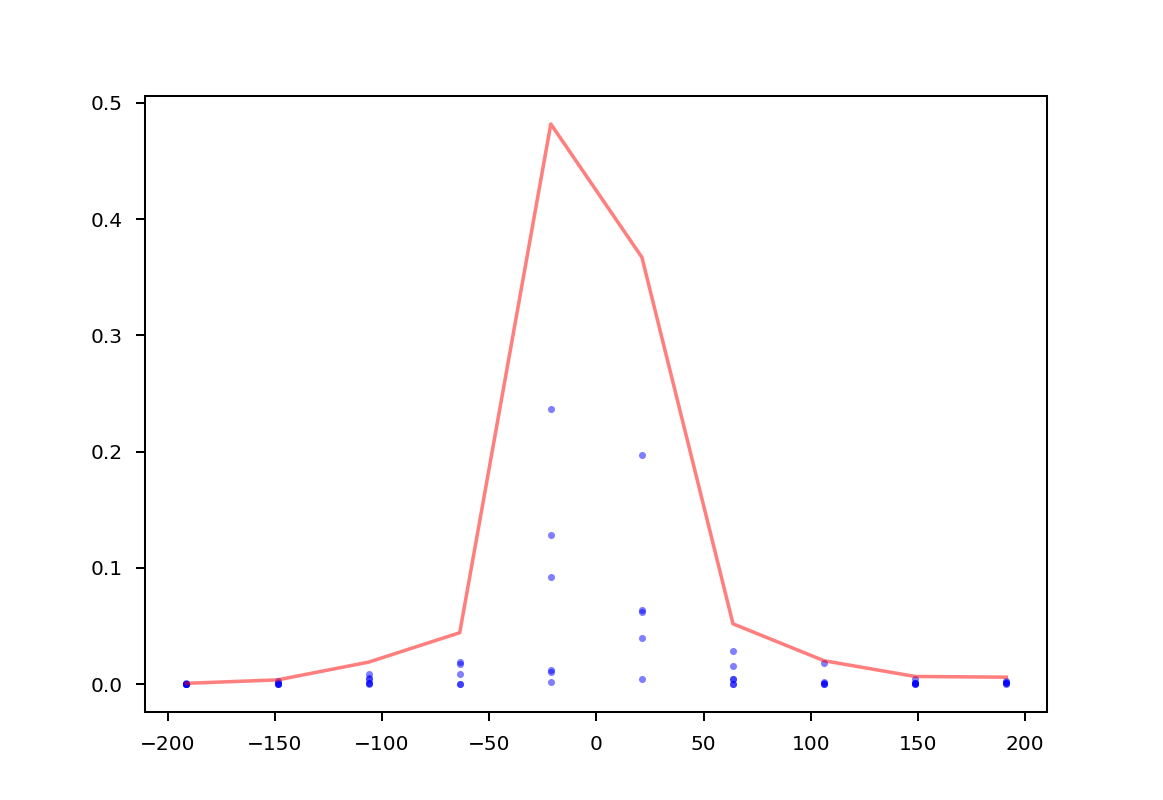

In [27]:
release_y = 27.5*ROWSPACE

df['dy'] = df['y']-release_y

fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.plot(df['dy'], df['rel catch'], '.', alpha=0.5, color='b')

cdy = df.groupby('dy')['rel catch'].sum()
ax.plot(cdy.index, cdy, 'r-', alpha=0.5)

<IPython.core.display.Javascript object>


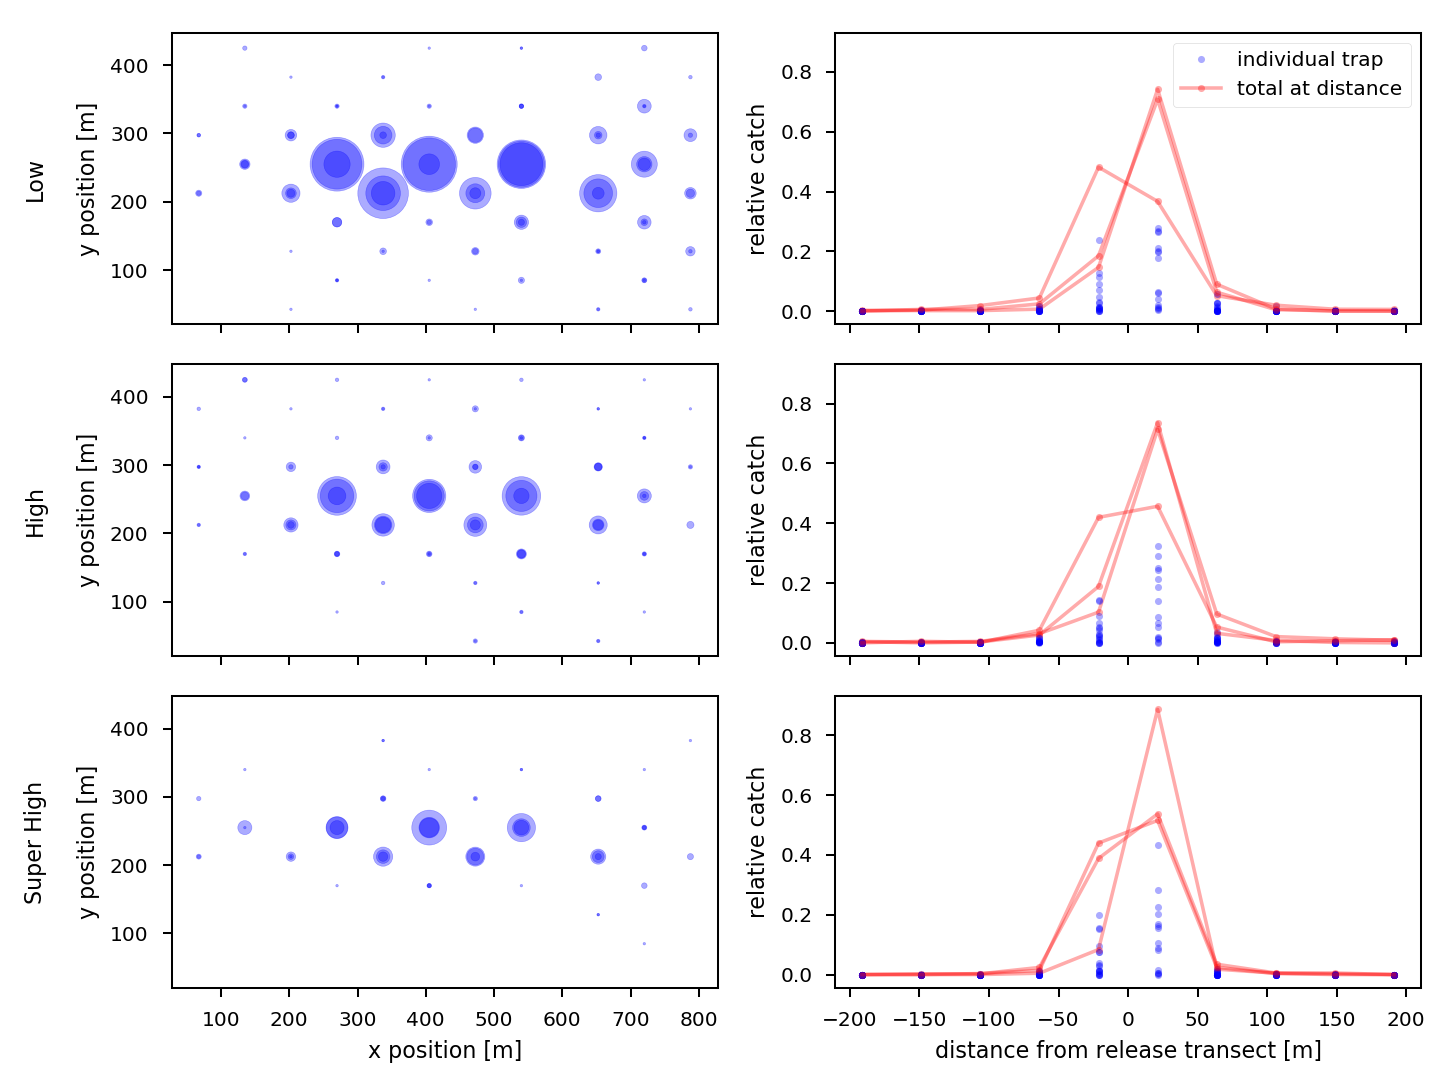

Service Dates: DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-05-04', '2017-05-08', '2017-05-18', '2017-05-22'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-06-01', '2017-06-05', '2017-06-15', '2017-06-19'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-05-04', '2017-05-08', '2017-05-18', '2017-05-22'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-06-01', '2017-06-05', '2017-06-15', '2017-06-19'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-05-04', '2017-05-08', '2017-05-18', '2017-05-22'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeI

In [28]:
# Load data and filter down to single service (collection date)
treatments = ['Low', 'High', 'Super High']
reps = [1,2,3]
service_number = 0
release_y = 27.5 * ROWSPACE

fig = plt.figure(figsize=[8,6])
#gs = mpl.gridspec.GridSpec(len(treatments),2)
axs = fig.subplots(len(treatments), 2, sharex='col', sharey='col')

for ti, treatment in enumerate(treatments):
    for rep in reps:
        
        df = load_rep_catch_data(rep, FN)
        df['x'] = df.apply(lambda r: tx0[int(r['Trap #'])-1] 
                           if int(r['Row']%10) == 5
                           else tx1[int(r['Trap #'])-1],
                           axis=1) 
        df['y'] = df['Row'] * ROWSPACE
#         full_df = df.copy()
#         df = full_df.copy()

        df = df[df['Treatment'] == treatment]
        service_dates = pd.to_datetime(df['Date Collected'].unique())
        print("Service Dates:", service_dates) # just informative output
        service_date = service_dates[service_number]
        df = df[df['Date Collected'] == service_date]

        df['rel catch'] = df['Total']/df['Total'].sum()
        df['dy'] = df['y']-release_y
        cdy = df.groupby('dy')['rel catch'].sum()

        ax = axs[ti,0]
        ax.scatter(df['x'], df['y'], df['Total'], color='b', alpha=0.33, label='trap catch')
        ax.set_aspect('equal')
        ax.set_ylabel('{}\n\ny position [m]'.format(treatment))

        ax = axs[ti,1]
        tmp, = ax.plot(df['dy'], df['rel catch'], '.', alpha=0.33, color='b', label='')
        if rep == reps[0]: tmp.set_label('individual trap')
        tmp, = ax.plot(cdy.index, cdy, 'r.-', alpha=0.33, label='')
        if rep == reps[0]: tmp.set_label('total at distance')
        ax.set_ylabel('relative catch')
    
axs[0,1].legend()
axs[-1,0].set_xlabel('x position [m]')
axs[-1,1].set_xlabel('distance from release transect [m]')

fig.tight_layout()


In [13]:
### Averaging the 3 reps

<IPython.core.display.Javascript object>


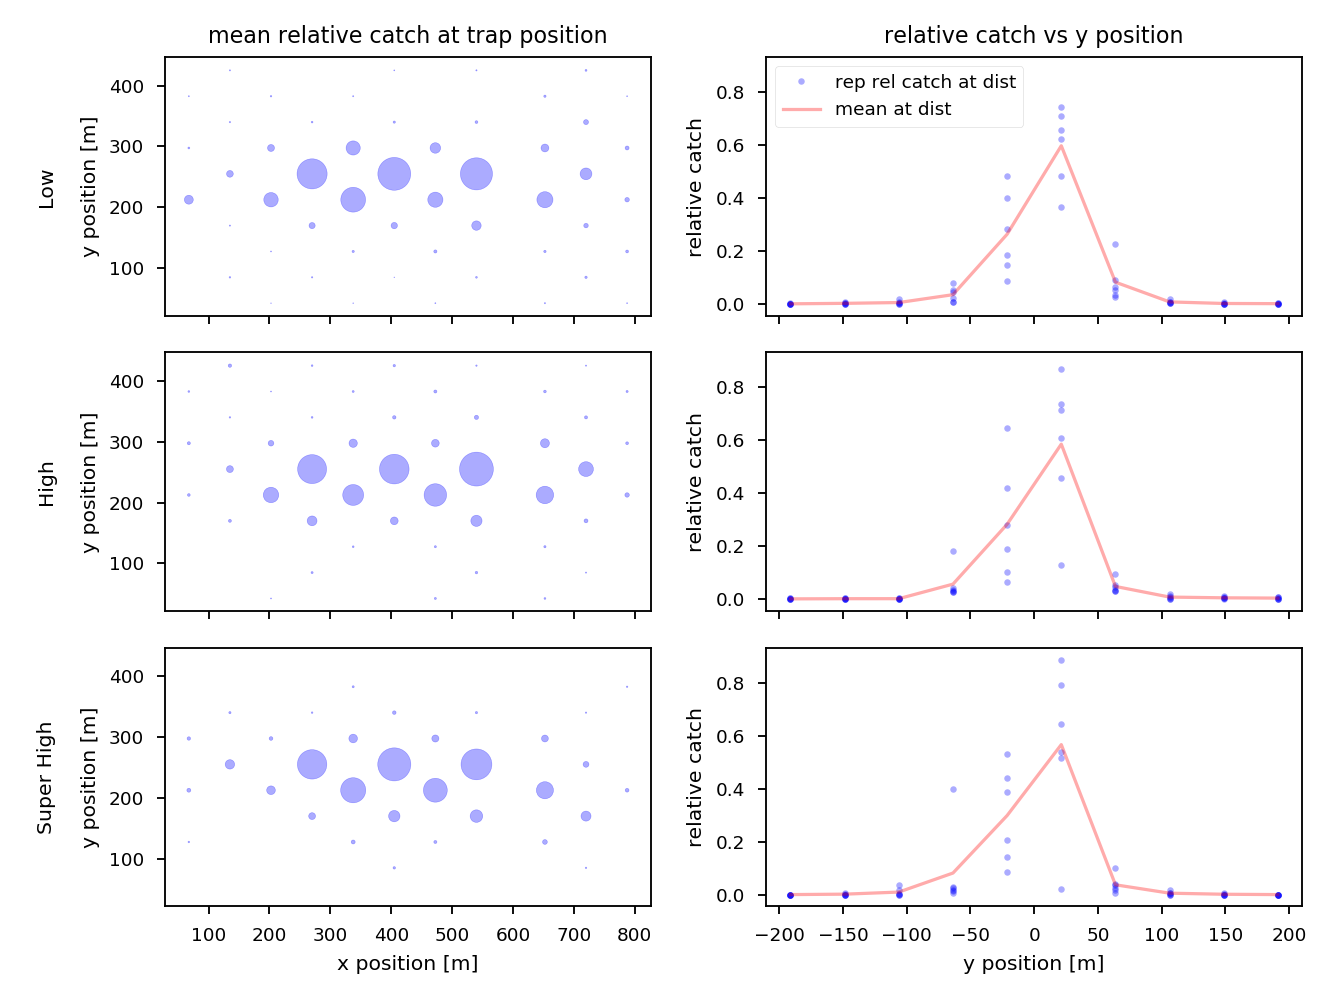

Service Dates: DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-05-04', '2017-05-08', '2017-05-18', '2017-05-22'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-06-01', '2017-06-05', '2017-06-15', '2017-06-19'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-08-03', '2017-08-07', '2017-08-17', '2017-08-21'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-08-24', '2017-08-28', '2017-09-07', '2017-09-11'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-09-14', '2017-09-18', '2017-09-28', '2017-10-02'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-05-04', '2017-05-08', '2017-05-18', '2017-05-22'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeI

In [122]:
# Load data and filter down to single service (collection date)
treatments = ['Low', 'High', 'Super High']
reps = [1,2,3,4,5,6]
service_number = 0
release_y = 27.5 * ROWSPACE
SCATTER_MARKER_SCALE = 1000

fig = plt.figure(figsize=[8,6])
axs = fig.subplots(len(treatments), 2, sharex='col', sharey='col', squeeze=False)

dys_by_treatment = {}
for ti, treatment in enumerate(treatments):
    dys = None
    sc = None
    for rep in reps:
        df = load_rep_catch_data(rep, FN)
        df['x'] = df.apply(lambda r: tx0[int(r['Trap #'])-1] 
                           if int(r['Row']%10) == 5
                           else tx1[int(r['Trap #'])-1],
                           axis=1) 
        df['y'] = df['Row'] * ROWSPACE
        df = df[df['Treatment'] == treatment]
        service_dates = pd.to_datetime(df['Date Collected'].unique())
        print("Service Dates:", service_dates) # just informative output
        service_date = service_dates[service_number]
        df = df[df['Date Collected'] == service_date]

        df['rel catch'] = df['Total']/df['Total'].sum()
        
#         if treatment == 'High':
#             df['rel catch'] = df['rel catch']*2
#         if treatment == 'Super High':
#             df['rel catch'] = df['rel catch']*4
            
        df['dy'] = df['y']-release_y
        cdy = df.groupby('dy')['rel catch'].sum()
        cdy.name = rep

        if dys is None:
            dys = cdy.to_frame()
            sc = df.copy().loc[:,['x','y','rel catch','dy']]
            sc.rename(columns={'rel catch':'rel catch{}'.format(rep)}, inplace=True)
        else:
            dys = dys.join(cdy.to_frame(), how='outer')
            sc = sc.merge(df.loc[:,['x','y','rel catch']].rename(columns={'rel catch':'rel catch{}'.format(rep)}),
                          how='outer', left_on=['x','y'], right_on=['x','y'], suffixes=['',rep])

    sc['mean'] = sc.loc[:,sc.columns.str.startswith('rel catch')].mean(axis=1)
    dys_by_treatment[treatment] = dys.copy()

    ax = axs[ti,0]
    ax.scatter(sc['x'], sc['y'], sc['mean']*SCATTER_MARKER_SCALE, color='b', alpha=0.33, label='mean relative trap catch')
    ax.set_aspect('equal')
    ax.set_ylabel('{}\n\ny position [m]'.format(treatment))

    ax = axs[ti,1]
    for rep in reps:
        tmp, = ax.plot(dys.index, dys.loc[:,rep], '.', alpha=0.33, color='b', label='')
        if rep == reps[0]: tmp.set_label('rep rel catch at dist')
    ax.plot(dys.index, dys.mean(axis=1), 'r-', alpha=0.33, label='mean at dist')
    ax.set_ylabel('relative catch')
    
axs[0,0].set_title('mean relative catch at trap position')
axs[0,1].set_title('relative catch vs y position')
axs[0,1].legend()
axs[-1,0].set_xlabel('x position [m]')
axs[-1,1].set_xlabel('y position [m]')

fig.tight_layout()

### Fit to gaussian (y position, not just distance)


<IPython.core.display.Javascript object>


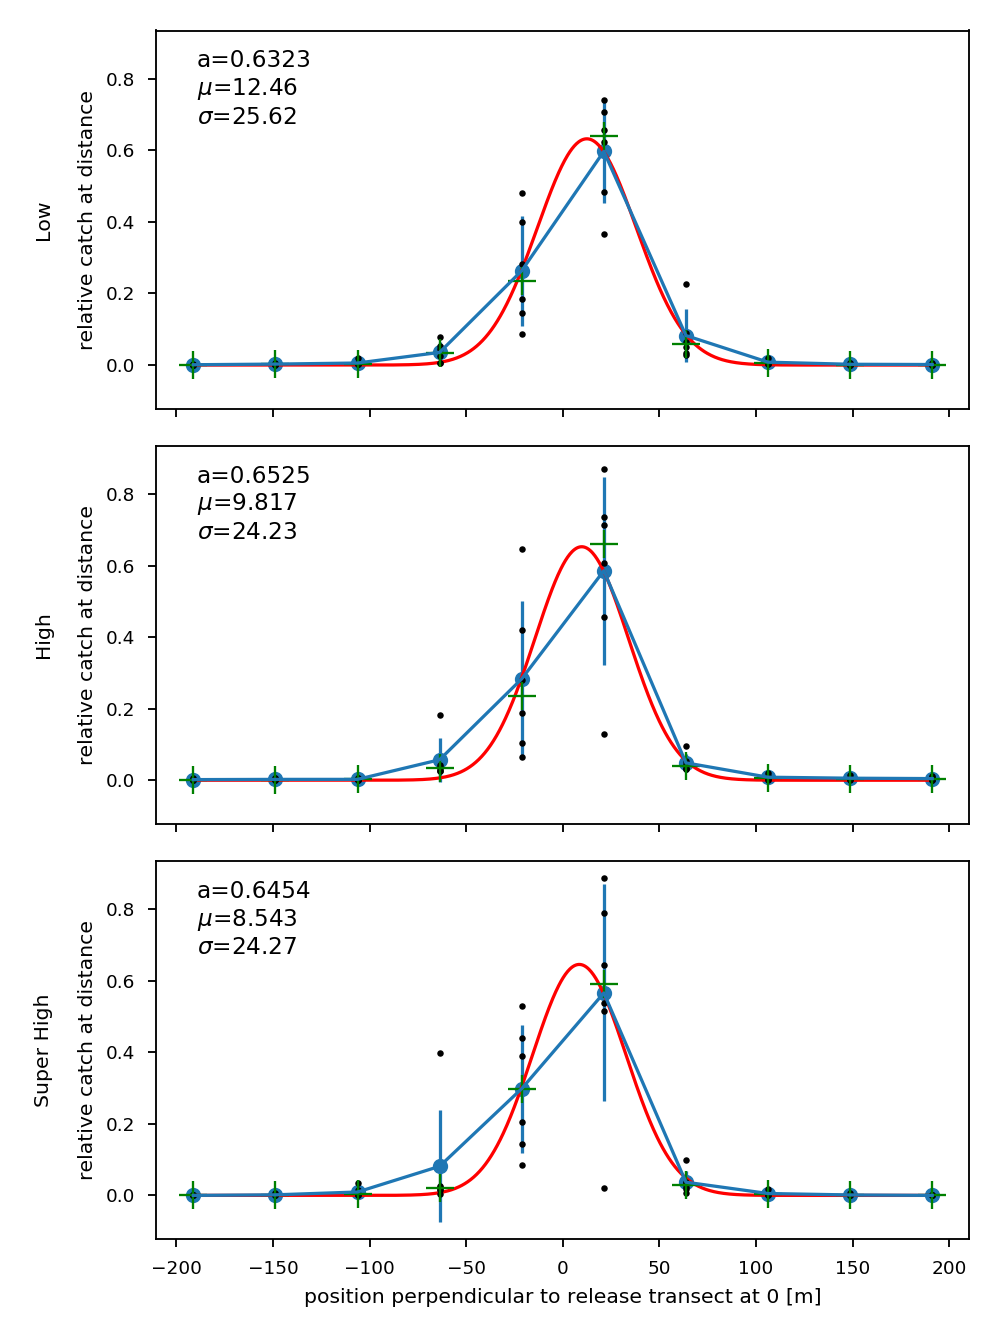

Low [ 0.63226567 12.46292406 25.61757947]
High [ 0.65252043  9.81730815 24.2260576 ]
Super High [ 0.64544991  8.54286689 24.27217109]


In [133]:
# Create a function which returns a Gaussian (normal) distribution.
def gauss(x, *p):
	a, b, c = p # b=mu, c=sigma (could also add d)
	y = a*np.exp(-np.power((x - b), 2.)/(2. * c**2.))# + d
	return y

treatments = ['Low', 'High', 'Super High']

fig = plt.figure(figsize=[6,8])
axs = fig.subplots(len(treatments), 1, sharex='col', sharey='col', squeeze=False)

for ti, treatment in enumerate(treatments):
    d = dys_by_treatment[treatment]
    d = d.stack().reset_index()
    d.rename(columns={'level_1':'rep', 0:'rc'}, inplace=True)

    N = 1000
    gb = d.groupby('dy')
    tmp = gb.mean()['rc']
    x = tmp.index.values
    y = tmp.values
    e = gb.std()['rc'].values

    y[y==0] = np.finfo(float).eps
    e[e==0] = np.finfo(float).eps
    
#     p_initial = [ 1,   5.87885532,  29.35313084]
    p_initial = [.1, (d['dy']*d['rc']).mean(), (d['dy']*d['rc']).std()]

    # Use curve_fit to fit
    popt, pcov = scipy.optimize.curve_fit(gauss, x, y, 
                                          #sigma=e, absolute_sigma=True,
                                          p0=p_initial, maxfev=1000)

    # Generate y-data based on the fit
    y_fit = gauss(x, *popt)
    print(treatment, popt)
    
    ax = axs[ti,0]
    ax.errorbar(x,y,e)
    ax.plot(x,y, 'o', mew=1, color='C0')
    x2 = np.linspace(x.min(), x.max(), N)
    ax.plot(x2, gauss(x2, *popt), color = 'red')
    
    ax.plot(d['dy'], d['rc'], 'k.')
    ax.plot(x, gb.median()['rc'], 'g+', mew=1, ms=12)
    
    ax.annotate("a={:.4g}\n$\\mu$={:.4g}\n$\\sigma$={:.4g}".format(*popt),
               xy=(.05,.95), xycoords='axes fraction',
               horizontalalignment='left', verticalalignment='top')
    ax.set_ylabel('{}\n\nrelative catch at distance'.format(treatment))
axs[-1,0].set_xlabel('position perpendicular to release transect at 0 [m]')
fig.tight_layout()

plt.savefig('foo.svg')

### Distance to transect fit


<IPython.core.display.Javascript object>


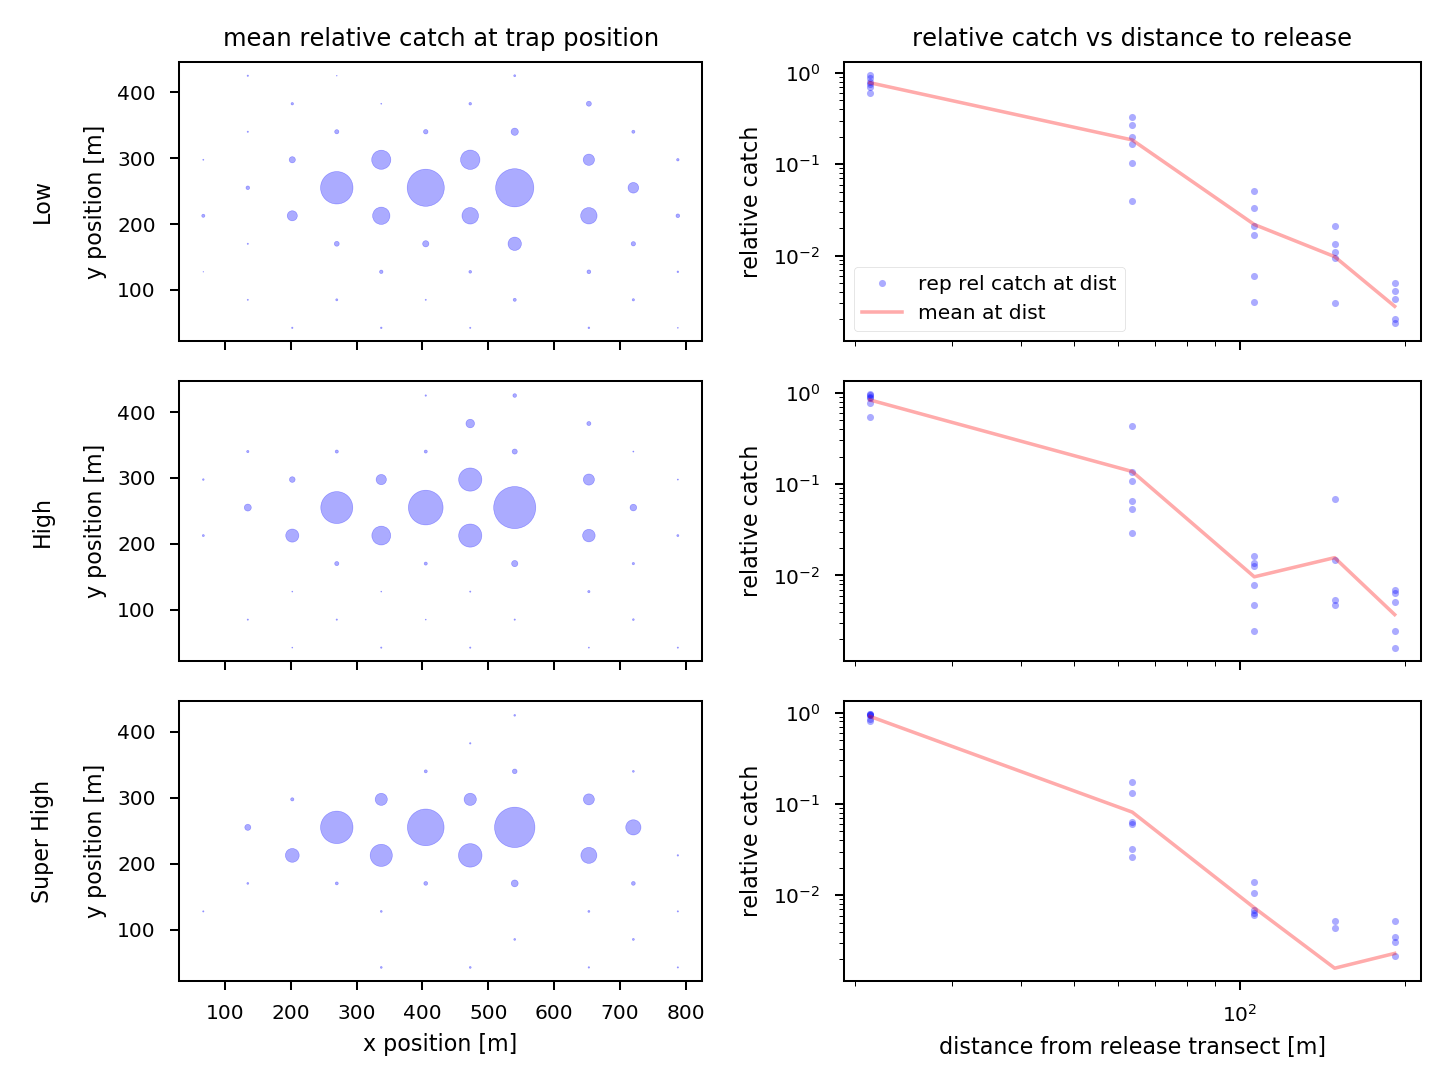

Service Dates: DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-05-04', '2017-05-08', '2017-05-18', '2017-05-22'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-06-01', '2017-06-05', '2017-06-15', '2017-06-19'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-08-03', '2017-08-07', '2017-08-17', '2017-08-21'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-08-24', '2017-08-28', '2017-09-07', '2017-09-11'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-09-14', '2017-09-18', '2017-09-28', '2017-10-02'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-05-04', '2017-05-08', '2017-05-18', '2017-05-22'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeI

In [119]:
# Load data and filter down to single service (collection date)
treatments = ['Low', 'High', 'Super High']
reps = [1,2,3,4,5,6]
service_number = 2
release_y = 27.5 * ROWSPACE
SCATTER_MARKER_SCALE = 1000

fig = plt.figure(figsize=[8,6])
axs = fig.subplots(len(treatments), 2, sharex='col', sharey='col', squeeze=False)

dys_by_treatment = {}
for ti, treatment in enumerate(treatments):
    dys = None
    sc = None
    for rep in reps:
        df = load_rep_catch_data(rep, FN)
        df['x'] = df.apply(lambda r: tx0[int(r['Trap #'])-1] 
                           if int(r['Row']%10) == 5
                           else tx1[int(r['Trap #'])-1],
                           axis=1) 
        df['y'] = df['Row'] * ROWSPACE
        df = df[df['Treatment'] == treatment]
        service_dates = pd.to_datetime(df['Date Collected'].unique())
        print("Service Dates:", service_dates) # just informative output
        service_date = service_dates[service_number]
        df = df[df['Date Collected'] == service_date]

        df['catch'] = df['Total']#/df['Total'].sum()
        df['rel catch'] = df['Total']/df['Total'].sum()

        df['dy'] = np.abs(df['y']-release_y)
        cdy = df.groupby('dy')['rel catch'].sum()
        cdy.name = rep

        if dys is None:
            dys = cdy.to_frame()
            sc = df.copy().loc[:,['x','y','rel catch','dy']]
            sc.rename(columns={'rel catch':'rel catch{}'.format(rep)}, inplace=True)
#             sc = df.copy().loc[:,['x','y','catch','dy']]
#             sc.rename(columns={'catch':'catch{}'.format(rep)}, inplace=True)
        else:
            dys = dys.join(cdy.to_frame(), how='outer')
            sc = sc.merge(df.loc[:,['x','y','rel catch']].rename(columns={'rel catch':'rel catch{}'.format(rep)}),
                          how='outer', left_on=['x','y'], right_on=['x','y'], suffixes=['',rep])
#             sc = sc.merge(df.loc[:,['x','y','catch']].rename(columns={'catch':'catch{}'.format(rep)}),
#                           how='outer', left_on=['x','y'], right_on=['x','y'], suffixes=['',rep])

    sc['mean'] = sc.loc[:,sc.columns.str.startswith('rel catch')].mean(axis=1)
#     sc['mean'] = sc.loc[:,sc.columns.str.startswith('catch')].mean(axis=1)
    dys_by_treatment[treatment] = dys.copy()

    ax = axs[ti,0]
    ax.scatter(sc['x'], sc['y'], sc['mean']*SCATTER_MARKER_SCALE, color='b', alpha=0.33, label='mean relative trap catch')
    ax.set_aspect('equal')
    ax.set_ylabel('{}\n\ny position [m]'.format(treatment))

    ax = axs[ti,1]
    for rep in reps:
        tmp, = ax.plot(dys.index, dys.loc[:,rep], '.', alpha=0.33, color='b', label='')
        if rep == reps[0]: tmp.set_label('rep rel catch at dist')
    ax.plot(dys.index, dys.mean(axis=1), 'r-', alpha=0.33, label='mean at dist')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('relative catch')

axs[0,0].set_title('mean relative catch at trap position')
axs[0,1].set_title('relative catch vs distance to release')
axs[0,1].legend()
axs[-1,0].set_xlabel('x position [m]')
axs[-1,1].set_xlabel('distance from release transect [m]')

fig.tight_layout()

In [120]:
for k,v in dys_by_treatment.items():
    print(k, v, v.mean(axis=1))

Low                1         2         3         4         5       6
dy                                                              
21.25   0.794335  0.599226  0.956025  0.755677  0.696072  0.8845
63.75   0.166256  0.331122  0.039578  0.198607  0.267402  0.1045
106.25  0.016626  0.051410  0.003078  0.033000  0.021365  0.0060
148.75  0.020936  0.013267  0.000880  0.009385  0.011027  0.0030
191.25  0.001847  0.004975  0.000440  0.003330  0.004135  0.0020 dy
21.25     0.780972
63.75     0.184578
106.25    0.021913
148.75    0.009749
191.25    0.002788
dtype: float64
High                1         2         3         4         5         6
dy                                                                
21.25   0.938158  0.779055  0.965812  0.540345  0.898921  0.880383
63.75   0.053947  0.134100  0.029304  0.431550  0.065751  0.108453
106.25  0.007895  0.012771  0.002442  0.016319  0.013739  0.004785
148.75  0.000000  0.068966  0.000000  0.005440  0.014720  0.004785
191.25  0.000000  0.0

In [39]:
dys_by_treatment

{'Low':                1         2         3
 dy                                  
 21.25   0.848824  0.888480  0.893536
 63.75   0.095882  0.096814  0.087996
 106.25  0.038824  0.009191  0.010864
 148.75  0.010000  0.001838  0.007061
 191.25  0.006471  0.003676  0.000543,
 'High':                1         2         3
 dy                                  
 21.25   0.816832  0.925104  0.876543
 63.75   0.127475  0.058252  0.095238
 106.25  0.025990  0.011096  0.005291
 148.75  0.016089  0.001387  0.012346
 191.25  0.013614  0.004161  0.010582,
 'Super High':                1         2         3
 dy                                  
 21.25   0.925532  0.970588  0.955326
 63.75   0.058511  0.022624  0.037801
 106.25  0.007979  0.004525  0.006873
 148.75  0.007979  0.002262  0.000000
 191.25  0.000000  0.000000  0.000000}

<IPython.core.display.Javascript object>


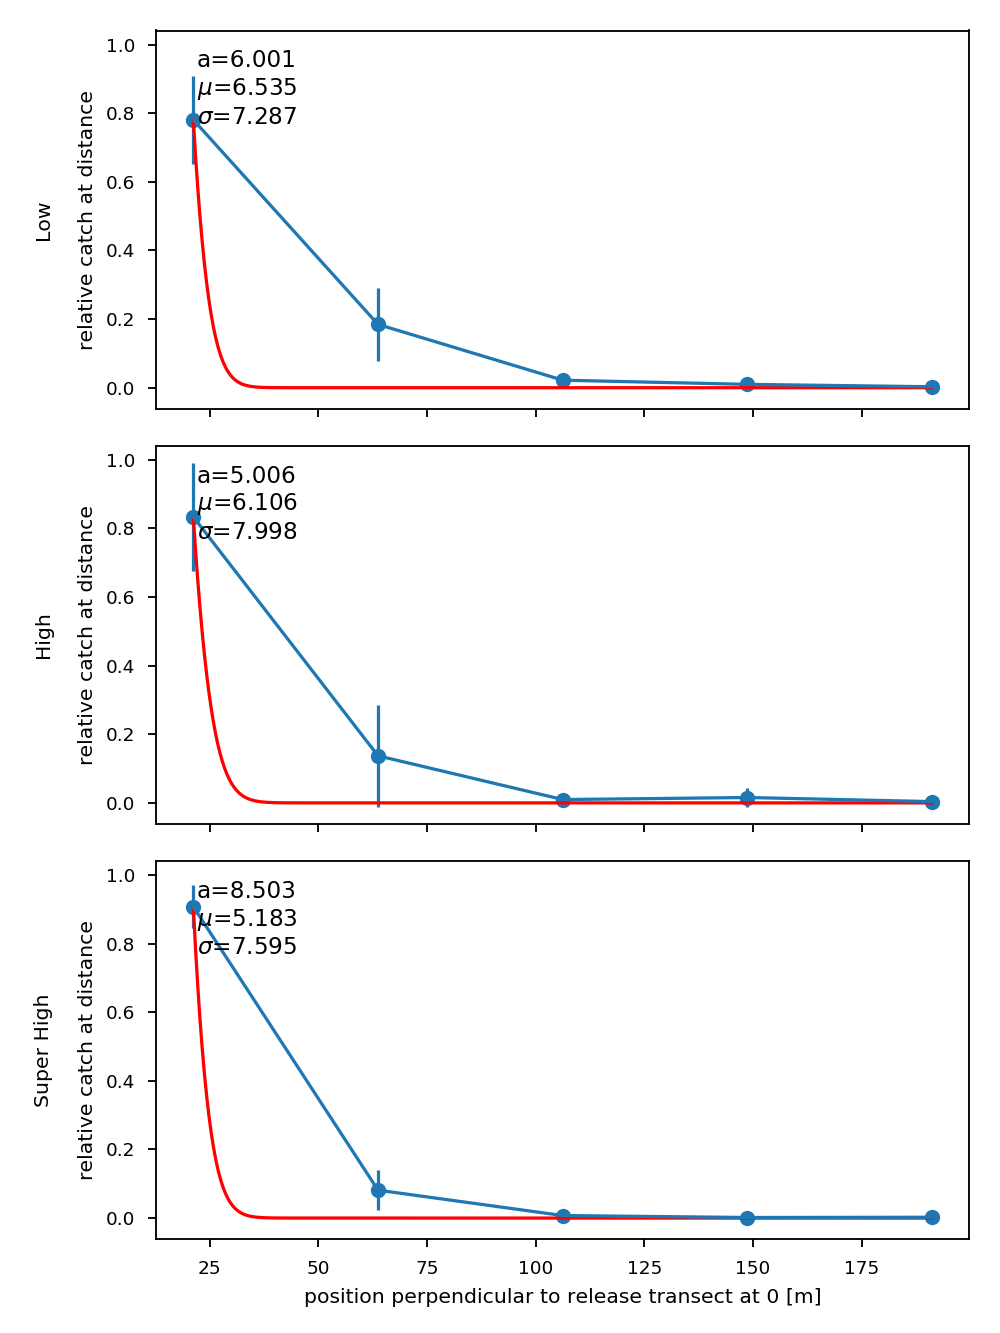

Low [6.00102374 6.53482342 7.28662398]
High [5.00612223 6.10609199 7.99833393]
Super High [8.50347162 5.18348909 7.59502955]


/home/travc/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [121]:
def gauss(x, *p):
	a, b, c = p # b=mu, c=sigma (could also add d)
	y = a*np.exp(-np.power((x - b), 2.)/(2. * c**2.))# + d
	return y

treatments = ['Low', 'High', 'Super High']

fig = plt.figure(figsize=[6,8])
axs = fig.subplots(len(treatments), 1, sharex='col', sharey='col', squeeze=False)

for ti, treatment in enumerate(treatments):
    d = dys_by_treatment[treatment]
    d = d.stack().reset_index()
    d.rename(columns={'level_1':'rep', 0:'rc'}, inplace=True)

    N = 1000
    gb = d.groupby('dy')
    tmp = gb.mean()['rc']
    x = tmp.index.values
    y = tmp.values
    e = gb.std()['rc'].values

    ## fit
    y[y==0] = np.finfo(float).eps
    e[e==0] = np.finfo(float).eps
    
#     p_initial = [ 1,   5.87885532,  29.35313084]
    p_initial = [.1, (d['dy']*d['rc']).mean(), (d['dy']*d['rc']).std()]

    # Use curve_fit to fit
    popt, pcov = scipy.optimize.curve_fit(gauss, x, y, sigma=e, absolute_sigma=True, p0=p_initial, maxfev=1000)

    # Generate y-data based on the fit
    y_fit = gauss(x, *popt)
    print(treatment, popt)
    
    ax = axs[ti,0]
    ax.errorbar(x,y,e)
    ax.plot(x,y, 'o', mew=1, color='C0')
    x2 = np.linspace(x.min(), x.max(), N)
    ax.plot(x2, gauss(x2, *popt), color = 'red')
    
    ax.annotate("a={:.4g}\n$\\mu$={:.4g}\n$\\sigma$={:.4g}".format(*popt),
               xy=(.05,.95), xycoords='axes fraction',
               horizontalalignment='left', verticalalignment='top')
    ax.set_ylabel('{}\n\nrelative catch at distance'.format(treatment))
axs[-1,0].set_xlabel('position perpendicular to release transect at 0 [m]')
fig.tight_layout()

<IPython.core.display.Javascript object>


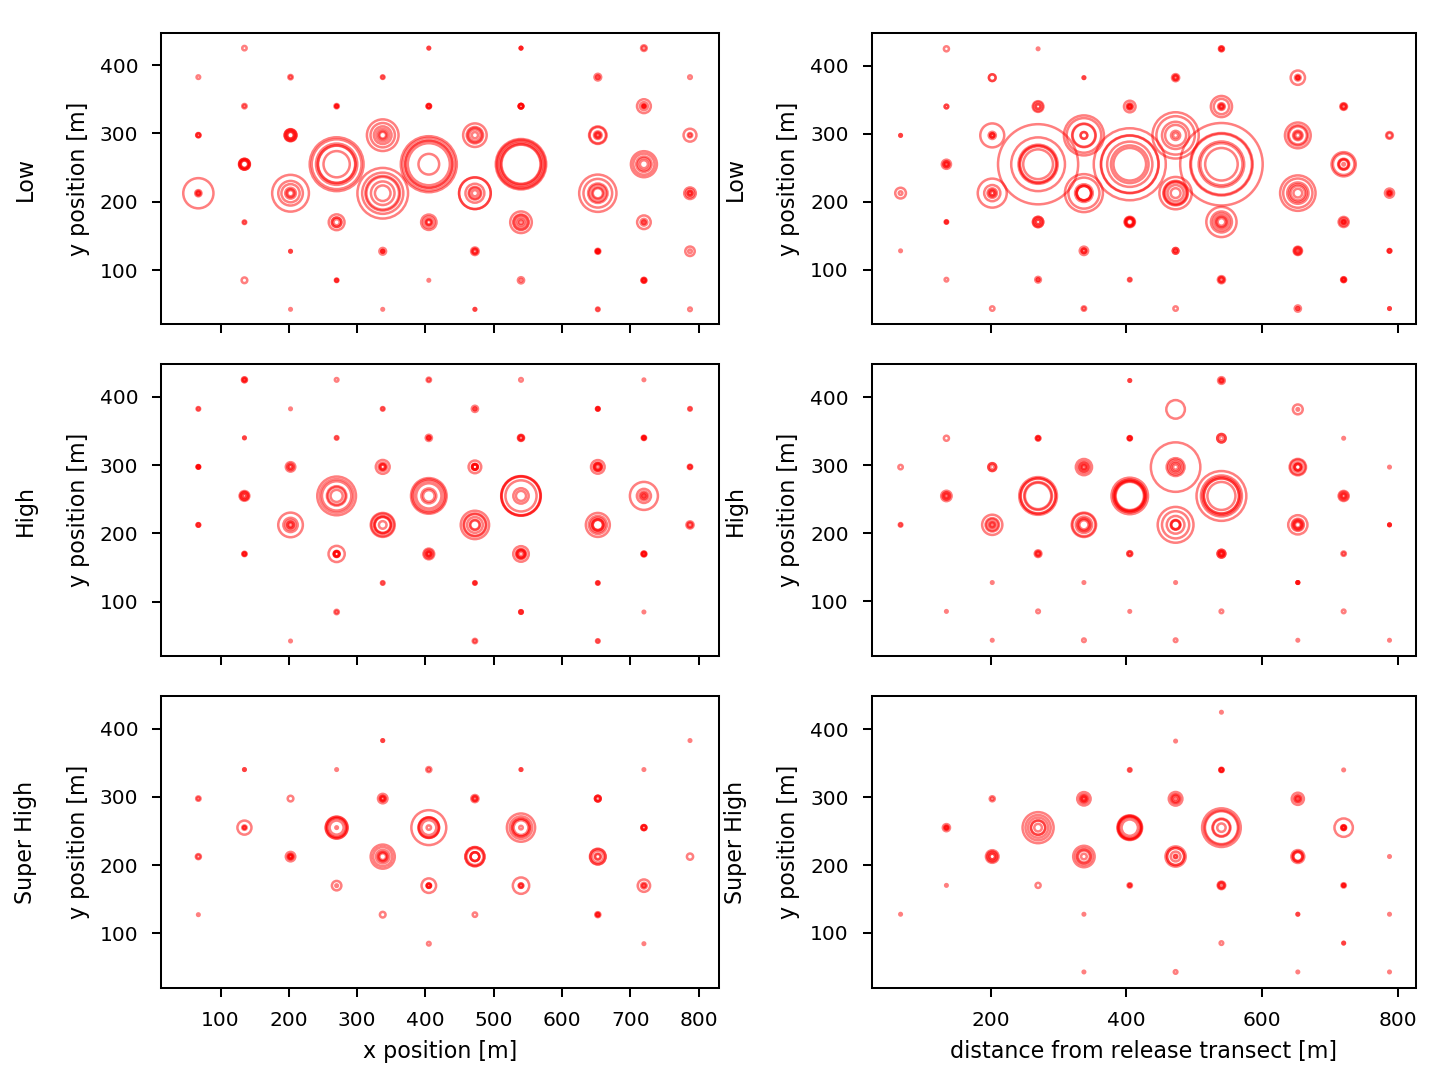

Service Dates: DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-05-04', '2017-05-08', '2017-05-18', '2017-05-22'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-06-01', '2017-06-05', '2017-06-15', '2017-06-19'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-08-03', '2017-08-07', '2017-08-17', '2017-08-21'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-08-24', '2017-08-28', '2017-09-07', '2017-09-11'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-09-14', '2017-09-18', '2017-09-28', '2017-10-02'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-05-04', '2017-05-08', '2017-05-18', '2017-05-22'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeI

In [116]:
# Load data and filter down to single service (collection date)
treatments = ['Low', 'High', 'Super High']
reps = [1,2,3,4,5,6]
service_numbers = [0, 2]
release_y = 27.5 * ROWSPACE
SCATTER_MARKER_SCALE = 1#000

fig = plt.figure(figsize=[8,6])
axs = fig.subplots(len(treatments), len(service_numbers), sharex='col', sharey='col', squeeze=False)

for si, service_number in enumerate(service_numbers):

    dys_by_treatment = {}
    for ti, treatment in enumerate(treatments):
        dys = None
        sc = None
        for rep in reps:
            df = load_rep_catch_data(rep, FN)
            df['x'] = df.apply(lambda r: tx0[int(r['Trap #'])-1] 
                               if int(r['Row']%10) == 5
                               else tx1[int(r['Trap #'])-1],
                               axis=1) 
            df['y'] = df['Row'] * ROWSPACE
            df = df[df['Treatment'] == treatment]
            service_dates = pd.to_datetime(df['Date Collected'].unique())
            print("Service Dates:", service_dates) # just informative output
        
            service_date = service_dates[service_number]
            df = df[df['Date Collected'] == service_date]

            df['catch'] = df['Total']#/df['Total'].sum()
            df['rel catch'] = df['Total']/df['Total'].sum()

            df['dy'] = np.abs(df['y']-release_y)
            cdy = df.groupby('dy')['rel catch'].sum()
            cdy.name = rep

            if dys is None:
                dys = cdy.to_frame()
    #             sc = df.copy().loc[:,['x','y','rel catch','dy']]
    #             sc.rename(columns={'rel catch':'rel catch{}'.format(rep)}, inplace=True)
                sc = df.copy().loc[:,['x','y','catch','dy']]
                sc.rename(columns={'catch':'catch{}'.format(rep)}, inplace=True)
            else:
                dys = dys.join(cdy.to_frame(), how='outer')
    #             sc = sc.merge(df.loc[:,['x','y','rel catch']].rename(columns={'rel catch':'rel catch{}'.format(rep)}),
    #                           how='outer', left_on=['x','y'], right_on=['x','y'], suffixes=['',rep])
                sc = sc.merge(df.loc[:,['x','y','catch']].rename(columns={'catch':'catch{}'.format(rep)}),
                              how='outer', left_on=['x','y'], right_on=['x','y'], suffixes=['',rep])

    #     sc['mean'] = sc.loc[:,sc.columns.str.startswith('rel catch')].mean(axis=1)
        sc['mean'] = sc.loc[:,sc.columns.str.startswith('catch')].mean(axis=1)
        dys_by_treatment[treatment] = dys.copy()

        ax = axs[ti,si]
#         ax.scatter(sc['x'], sc['y'], sc['catch1']*SCATTER_MARKER_SCALE,
#                    color='b', alpha=0.33, label='rep1 catch')    
        for rep in reps:
            ax.scatter(sc['x'], sc['y'], sc['catch{}'.format(rep)]*SCATTER_MARKER_SCALE,
                   alpha=0.5, edgecolor='r', linewidths=1, facecolor='none',
                   label='rep{} catch'.format(rep))
        ax.set_aspect('equal')
        ax.set_ylabel('{}\n\ny position [m]'.format(treatment))

#     ax = axs[ti,1]
#     for rep in reps:
#         tmp, = ax.plot(dys.index, dys.loc[:,rep], '.', alpha=0.33, color='b', label='')
#         if rep == reps[0]: tmp.set_label('rep rel catch at dist')
#     ax.plot(dys.index, dys.mean(axis=1), 'r-', alpha=0.33, label='mean at dist')
#     ax.set_xscale('log')
#     ax.set_yscale('log')
#     ax.set_ylabel('relative catch')

# axs[0,1].legend()
axs[-1,0].set_xlabel('x position [m]')
axs[-1,1].set_xlabel('distance from release transect [m]')

fig.tight_layout()

# paper fig

### Estimated kill vs dy

In [137]:
# Get the estimated number of potential responders released (number catchable)
TOTAL_NUM_FLIES = 12600
fn = '2018-05_data.csv'
d = pd.read_csv(fn)
fraction_male = 0.5
d['catchable'] = TOTAL_NUM_FLIES*fraction_male*d['Emergence']*d['Flight']*d['Me-response']
d

,date,rep,age,treatment,plot,no. recap,estkill,Emergence,Flight,Me-response,pctkill,protein-F,protein-M,treatage,catchable
0,4/12/2017,1,01d,110skm,A,1746,1746,0.895,0.855,0.850,0.426084,2,0,01d110,4097.779875
1,5/3/2017,2,01d,110skm,C,1669,1669,0.900,0.880,0.733,0.456338,4,0,01d110,3657.376800
2,5/31/2017,3,01d,110skm,B,1951,1951,0.905,0.820,0.733,0.569312,6,0,01d110,3426.943590
3,8/1/2017,4,01d,110skm,A,1594,1594,0.980,0.860,0.933,0.321767,9,0,01d110,4953.894120
4,8/23/2017,5,01d,110skm,C,1372,1372,0.970,0.840,0.967,0.276399,17,0,01d110,4963.843080
5,9/13/2017,6,01d,110skm,B,1732,1732,0.930,0.875,0.967,0.349373,5,1,01d110,4957.446375
6,4/26/2017,1,14d,110skm,A,1664,1664,0.905,0.870,0.967,0.346911,2,0,14d110,4796.614935
7,5/17/2017,2,14d,110skm,C,1941,1941,0.895,0.855,0.967,0.416360,6,1,14d110,4661.827223
8,6/14/2017,3,14d,110skm,B,2365,2365,0.925,0.855,0.933,0.508746,10,2,14d110,4648.684162
9,8/16/2017,4,14d,110skm,A,3331,3331,0.990,0.830,0.867,0.742167,14,2,14d110,4488.207570


In [147]:
# should be no difference between treatments (so every rep,age group has 0 std)
assert all(d.groupby(['rep','age'])['catchable'].std() == 0)
catchable = d.groupby(['rep','age'])['catchable'].mean()

In [257]:
# Load data and filter down to single service (collection date)
treatments = ['Low', 'High', 'Super High']
reps = [1,2,3,4,5,6]
service_number = [0,2]
release_y = 27.5 * ROWSPACE
SCATTER_MARKER_SCALE = 1#000

dys_by_treatment = {}

for si, service_number in enumerate(service_numbers):
    for ti, treatment in enumerate(treatments):
        dys = None
        sc = None
        for rep in reps:
            print('Rep', rep, treatment, service_number)
            df = load_rep_catch_data(rep, FN)
            df['x'] = df.apply(lambda r: tx0[int(r['Trap #'])-1] 
                               if int(r['Row']%10) == 5
                               else tx1[int(r['Trap #'])-1],
                               axis=1) 
            df['y'] = df['Row'] * ROWSPACE
            df = df[df['Treatment'] == treatment]
            service_dates = pd.to_datetime(df['Date Collected'].unique())
#             print("Service Dates:", service_dates) # just informative output
            service_date = service_dates[service_number]
            df = df[df['Date Collected'] == service_date]
            df['catch'] = df['Total']

            if treatment == 'High':
                df['catch'] = df['catch']*2
            if treatment == 'Super High':
                df['catch'] = df['catch']*4

            if service_number in [0,1]:
                age = '01d'
            else:
                age = '14d'
            total_catch = df['catch'].sum()
#             df['rel catch'] = df['catch'] / df['catch'].sum()
            df['%catch'] = 100*df['catch'] / catchable.loc[(rep,age)]
                
            df['dy'] = df['y']-release_y
            cdy = df.groupby('dy')['%catch'].sum()
            cdy.name = rep

            if dys is None:
                dys = cdy.to_frame()
                sc = df.copy().loc[:,['x','y','catch','dy']]
                sc.rename(columns={'catch':'catch{}'.format(rep)}, inplace=True)
            else:
                dys = dys.join(cdy.to_frame(), how='outer')
                sc = sc.merge(df.loc[:,['x','y','catch']].rename(columns={'catch':'catch{}'.format(rep)}),
                              how='outer', left_on=['x','y'], right_on=['x','y'], suffixes=['',rep])

        sc['mean'] = sc.loc[:,sc.columns.str.startswith('catch')].mean(axis=1)
        dys_by_treatment[treatment+str(si)] = dys.copy()

Rep 1 Low 0
Rep 2 Low 0
Rep 3 Low 0
Rep 4 Low 0
Rep 5 Low 0
Rep 6 Low 0
Rep 1 High 0
Rep 2 High 0
Rep 3 High 0
Rep 4 High 0
Rep 5 High 0
Rep 6 High 0
Rep 1 Super High 0
Rep 2 Super High 0
Rep 3 Super High 0
Rep 4 Super High 0
Rep 5 Super High 0
Rep 6 Super High 0
Rep 1 Low 2
Rep 2 Low 2
Rep 3 Low 2
Rep 4 Low 2
Rep 5 Low 2
Rep 6 Low 2
Rep 1 High 2
Rep 2 High 2
Rep 3 High 2
Rep 4 High 2
Rep 5 High 2
Rep 6 High 2
Rep 1 Super High 2
Rep 2 Super High 2
Rep 3 Super High 2
Rep 4 Super High 2
Rep 5 Super High 2
Rep 6 Super High 2


In [188]:
dys_by_treatment

{'Low0':                  1          2          3          4          5          6
 dy                                                                       
 -191.25   0.024403   0.136710   0.029181   0.000000   0.040291   0.000000
 -148.75   0.146421   0.082026   0.320986   0.000000   0.040291   0.121030
 -106.25   0.780911   0.082026   0.320986   0.060558   0.080583   0.100858
 -63.75    1.830259   0.300762   1.313123   1.655263   0.161165   2.723176
 -21.25   19.986432   6.534738   9.950558   8.861715   2.336899  13.898284
  21.25   15.227758  33.111163  38.051400  19.600742  17.969948  16.803006
  63.75    2.147504   4.019274   3.414121   1.090052   6.225015   0.948069
  106.25   0.829718   0.328104   0.262625   0.121117   0.261894   0.100858
  148.75   0.268438   0.000000   0.058361   0.000000   0.141020   0.020172
  191.25   0.244035   0.027342   0.000000   0.000000   0.060437   0.020172,
 'High0':                  1          2          3          4          5          6
 dy    

<IPython.core.display.Javascript object>


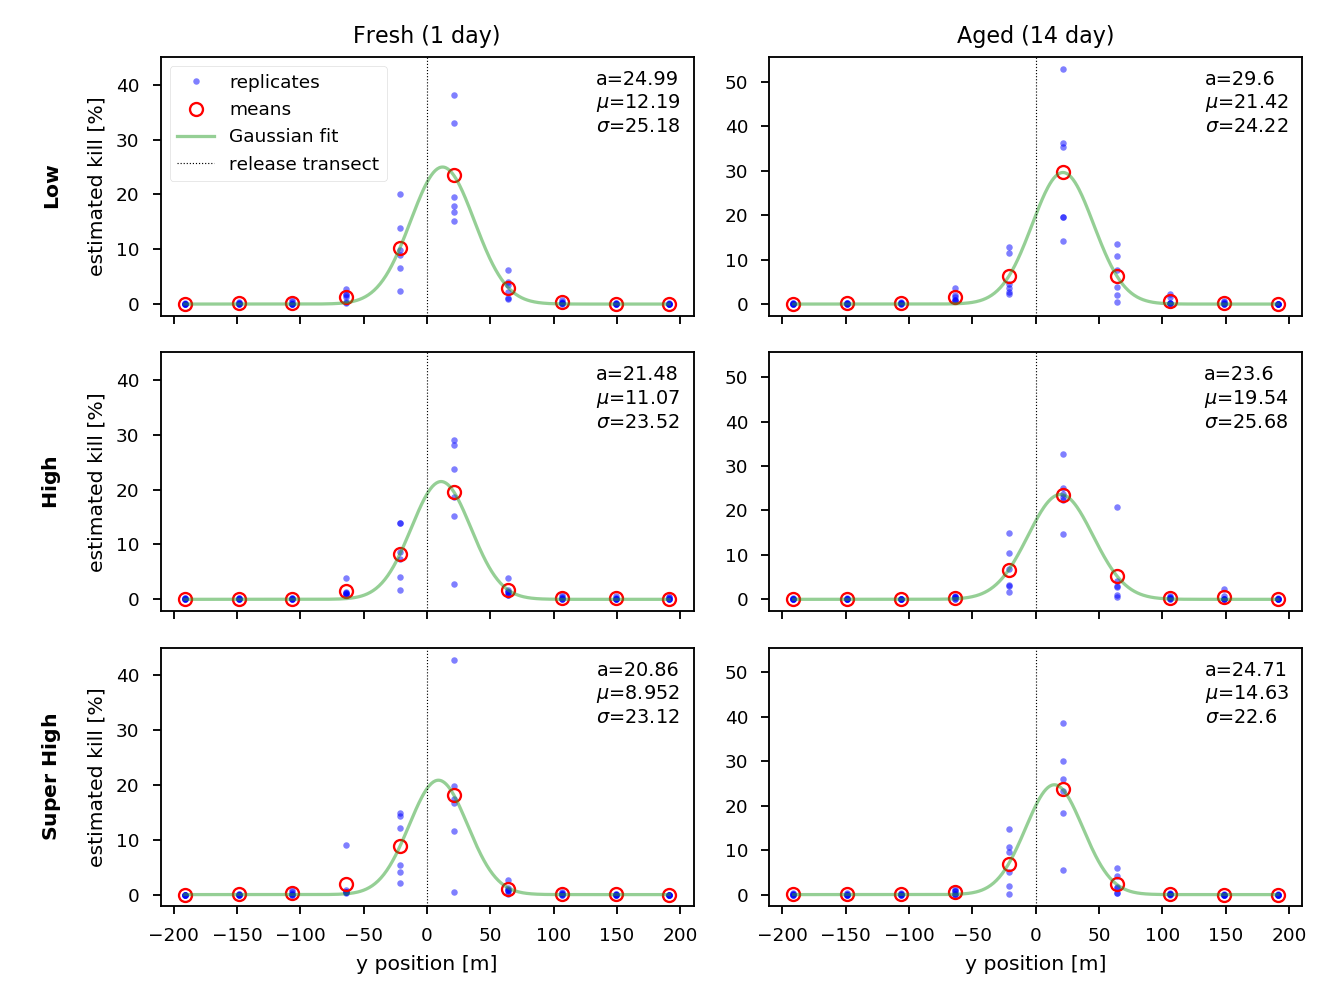

Low0
High0
Super High0
Low1
High1
Super High1


In [268]:
# plot
# Using: dys_by_treatment created above

# function to fit
def gauss(x, *p):
    a, b, c = p # b=mu, c=sigma^2 (could also add d)
    y = a*np.exp(-np.power((x - b), 2.)/(2. * c))# + d
    return y

fig = plt.figure(figsize=[8,6])
axs = fig.subplots(len(treatments), len(service_numbers),
                   sharex='col', sharey='col', squeeze=False)

for si, service_number in enumerate(service_numbers):
    for ti, treatment in enumerate(treatments):

        ax = axs[ti,si]
        d = dys_by_treatment[treatment+str(si)].copy(deep=True)

#         # smoothed line
#         x = d.index
#         y = d.mean(axis=1)
#         tmpx = np.linspace(d.index.min(), d.index.max(), 500)
#         tmpy = scipy.interpolate.InterpolatedUnivariateSpline(x,y)(tmpx)
#         ax.plot(tmpx, tmpy, 'r-', lw=.5)
        
        for rep in reps:
            tmp, = ax.plot(d.index, d.loc[:,rep], '.', alpha=0.5, color='b',
                           label='', zorder=1)
            if rep == reps[0]: tmp.set_label('replicates')
        ax.plot(d.index, d.mean(axis=1),
                'o', lw=0.5, color='r', markerfacecolor='None', markeredgewidth=1,
                label='means')
        
        ## Fit to Gaussian
        d = dys_by_treatment[treatment+str(si)].copy(deep=True)
        d = d.stack().reset_index()
        d.rename(columns={'level_1':'rep', 0:'rc'}, inplace=True)
        print(treatment+str(si))
        
        # Use curve_fit to fit
        N = 500  # just number of points to use when drawing fit curve
        x = d['dy'].values
        y = d['rc'].values
        y[y==0] = np.finfo(float).eps # add epsilon to 0 to avoid confusing the solver
        p_initial = [.1, (d['dy']*d['rc']).mean(), (d['dy']*d['rc']).std()]
        popt, pcov = scipy.optimize.curve_fit(gauss, x, y, 
                                              p0=p_initial, maxfev=1000)
        # plot fit
        x2 = np.linspace(x.min(), x.max(), N)
        ax.plot(x2, gauss(x2, *popt), color = 'C2', alpha=0.5, label='Gaussian fit')

        popt[2] = np.sqrt(popt[2])
        ax.annotate("a={:.4g}\n$\\mu$={:.4g}\n$\\sigma$={:.4g}".format(*popt),
                   xy=(.975,.95), xycoords='axes fraction',
                   horizontalalignment='right', verticalalignment='top', ma='left',
                   fontsize='small')        

        # transect location and labels
        ax.axvline(x=0, color='k', ls=':', lw=0.5, label='release transect')
        tmp = treatment
        if si==0:
            ax.set_ylabel('$\\mathrm{{\\mathbf{{{}}}}}$\n\nestimated kill [%]'.
                          format(treatment.replace(' ','\ ')))
        
# overall annotations
axs[0,0].set_title('Fresh (1 day)')# (service #{})'.format(service_numbers[0]))
axs[0,1].set_title('Aged (14 day)')# (service #{})'.format(service_numbers[1]))

axs[0,0].legend(loc='upper left')
for ax in axs[-1,:]:
    ax.set_xlabel('y position [m]')

fig.tight_layout()
plt.savefig('fig2.pdf')

In [169]:
22*2+4*31+4*16+2*8+80+69+15+9+10+11+11+37

490